In [90]:
import cupy as cp 
import numpy as np
import matplotlib.pyplot as plt
import time as t




n = 100000
nt = 1000
dt = 0.001
T = nt * dt
A = 1

# If thy GPU doesn't have sufficient memory, reduce teh above parameters and also at the bottom you will fine more base_values in a cell.

# trajs = cp.random.normal(size=(n, nt+1))*cp.sqrt(A*A*dt)
# trajs = cp.cumsum(trajs, axis=1)
# trajs = (trajs).get()
# #Make the nt+1 value = NaN
# min_val = np.min(trajs)
# max_val = np.max(trajs)
# trajs[:, -1] = np.nan


In [91]:
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datashader as ds
import datashader.transfer_functions as tf
from datashader.utils import export_image
from datashader.datatypes import RaggedArray
from matplotlib import colors
import colorsys as cs 

In [112]:
# Optional colormaps
try:
    import colorcet as cc
    DENSITY_CMAP = cc.fire
except Exception:
    DENSITY_CMAP = "Blues"


def generate_image(
    data: np.ndarray,
    dt: float,
    n: int,
    nt: int,
    min_val:float,
    max_val:float,
    out_png="all_trajectories_overlay.png",
    plot_width=1400,
    plot_height=800,
    background="black",
    xlabel="Time(seconds)",
    ylabel="Displacement(arbitrary units)"
):
    n, nt = data.shape
    t = np.arange(nt, dtype=np.float32) * dt

    x_range = (0, dt*nt)
    y_range = (min_val, max_val)

    cvs = ds.Canvas(
        plot_width=plot_width,
        plot_height=plot_height,
        x_range=x_range,
        y_range=y_range,
    )

    df_all = pd.DataFrame({
        "time": np.tile(t, n),
        "val":  data.reshape(-1),
        "id":   np.repeat(np.arange(n), nt),
    })
    
    
    agg_all = cvs.line(df_all, x="time", y="val", agg=ds.count())

    img = tf.shade(agg_all, cmap=DENSITY_CMAP, how="log")
    img = tf.set_background(img, background)
    img = tf.dynspread(img, threshold=0.1, max_px=2)

    # export_image(img, out_png.replace(".png", ""), fmt=".png")
    
    fig, ax = plt.subplots(figsize=(10, 5), dpi=150)

   
    ax.imshow(
        img.to_pil(),
        extent=[0, dt*(nt-1), min_val, max_val],
        origin="lower",
        aspect="auto",
    )
    ax.tick_params(colors="white")
    for spine in ax.spines.values():
        spine.set_color("white")
    ax.set_facecolor("black")
    ax.set_xlabel(xlabel, color="white")
    ax.set_ylabel(ylabel, color="white")
    fig.patch.set_facecolor("black")
    plt.title(f"All Trajectories, n={n}, dt={dt:.5g}, T={T:.5g}", color="white")

    plt.tight_layout()
    plt.savefig(out_png)
    


    return img



In [132]:

t0 = t.perf_counter()
trajs = cp.random.normal(size=(n, nt+1)) * cp.sqrt(A * A * dt)
trajs = cp.cumsum(trajs, axis=1)
t1 = t.perf_counter()
trajs = (trajs).get()
#Make the nt+1 value = NaN
min_val = np.min(trajs)
max_val = np.max(trajs)
max_magnitude = np.max([np.abs(min_val), np.abs(max_val)])
min_val = -max_magnitude
max_val = max_magnitude
trajs[:, -1] = np.nan



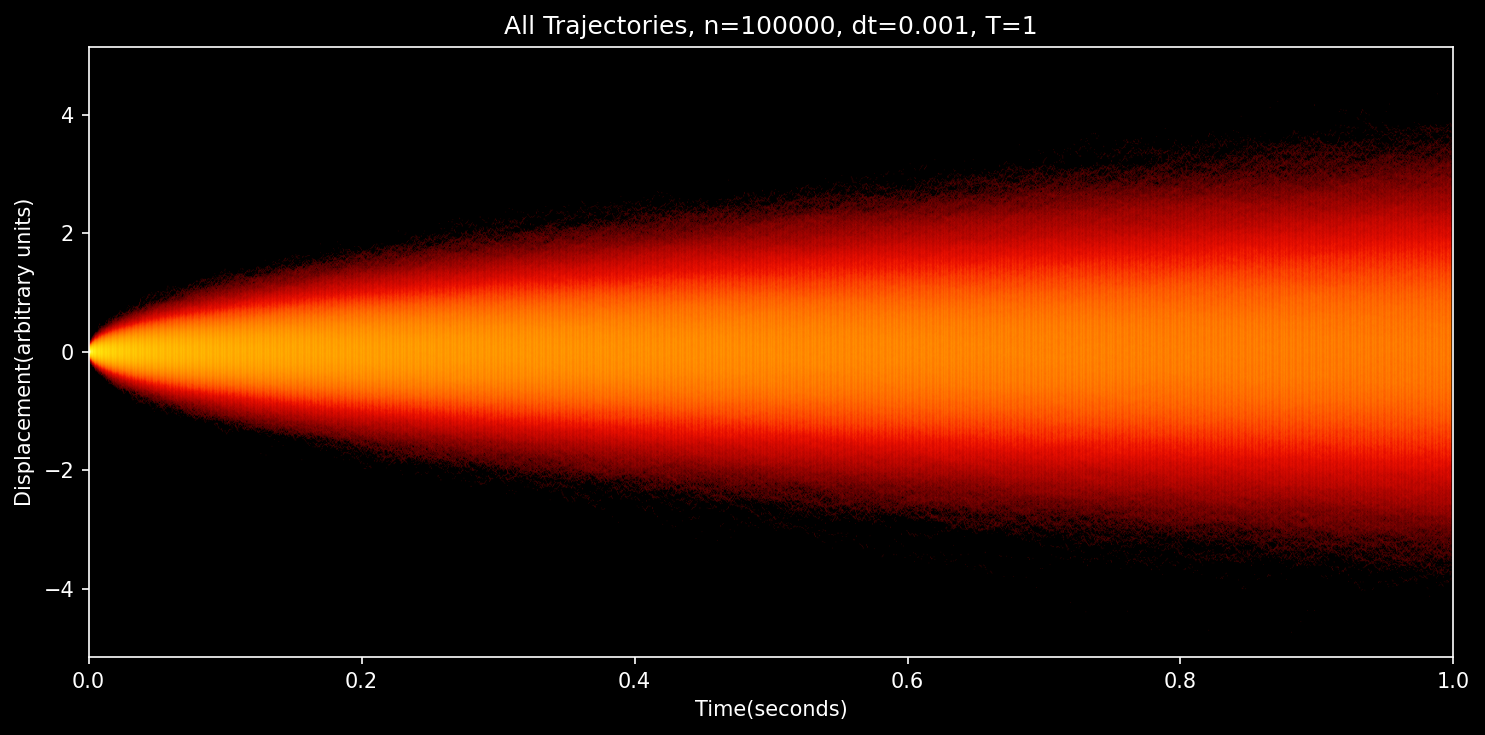

In [104]:
generate_image(
    trajs,
    dt=dt,
    n=n,
    nt=nt,
    out_png=f"images/all_trajectories_overlay_n-{n}_dt-{dt:.5g}_T-{T:.5g}.png",
    plot_width=1600,
    plot_height=900,
    min_val=min_val,
    max_val=max_val,
);

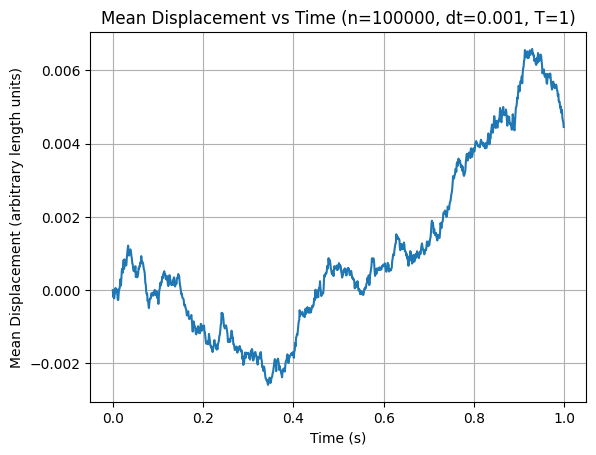

In [133]:
def plt_settings(title:str, xlabel:str, ylabel:str, colour:str='blue'):

    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.grid()
    plt.savefig(f"images/{title}.png")
    plt.show()
    


# trajs = cp.random.normal(size=(n, nt))* A*np.sqrt(dt)
        
# trajs = cp.cumsum(trajs, axis=1)
# trajs_mean = cp.mean(trajs, axis=0)
mean_displacement_vs_time = cp.mean(trajs, axis=0)
plt.plot(np.arange(nt+1)*dt, mean_displacement_vs_time)
plt_settings(f"Mean Displacement vs Time (n={n}, dt={dt:.5g}, T={T:.5g})", "Time (s)", "Mean Displacement (arbitrary length units)")
trajs = 0
# msd_vs_time = cp.square(trajs)

In [163]:
def perform_studies_01(n_min, n_factor, n_pow, nt, dt):
    # mean_x_vals = []
    # mean_x_sq_vals = []
    A = 1
    n_n = n_pow+1
    f1, ax_mean = plt.subplots(figsize=(10, 5), dpi=150)
    f2, ax_mean_sq = plt.subplots(figsize=(10, 5), dpi=150)
    f3, ax_mean_log = plt.subplots(figsize=(7, 7), dpi=150)

    time_vals = [(i) * dt for i in range(nt)]
    
    ax_mean.plot(time_vals, [0]*len(time_vals), label=f"<x> = 0", color='black')
    ax_mean_sq.plot(time_vals, A*A*time_vals, label=f"<x^2> ~ t", color='black')
    ax_mean_log.loglog(time_vals, A*A*time_vals, label=f"<x^2> ~ t", color='black')
    
    for i in range(0, n_n):
        n = n_min *(n_factor ** i)
        trajs = cp.random.normal(size=(n, nt))* A*np.sqrt(dt)
        
        trajs = cp.cumsum(trajs, axis=1)
        trajs_mean = cp.mean(trajs, axis=0)
        trajs_sq= cp.square(trajs)
        trajs_sq_mean = cp.mean(trajs_sq, axis=0)
        t_measure_high_fraction = 0.9
        t_measure_low_fraction = 0.2
        high_t = round(nt*t_measure_high_fraction)
        low_t = round(nt*t_measure_low_fraction)
        alpha = np.log(trajs_sq_mean[high_t]/trajs_sq_mean[low_t])/np.log(high_t/low_t)
        print(f"Log-Log slope for n={n} and dt={dt}: {alpha}")



        ax_mean.plot(time_vals, trajs_mean.get(), label=f"n={n}, dt={dt}")
        ax_mean_sq.plot(time_vals, trajs_sq_mean.get(), label=f"n={n}, dt={dt}")
        ax_mean_log.loglog(time_vals, trajs_sq_mean.get(), label=f"n={n}, dt={dt}")

    ax_mean.legend()
    ax_mean_sq.legend()
    ax_mean_log.legend()
    
    ax_mean.set_title("Mean Displacement vs Time (Verifying Law of Large Numbers)")
    ax_mean_sq.set_title("Mean Squared Displacement vs Time for different n")
    ax_mean_log.set_title("Mean Log Displacement vs Time for different n")
    
    ax_mean.set_xlabel("Time (s)")
    ax_mean_sq.set_xlabel("Time (s)")
    ax_mean_log.set_xlabel("Time (s)")
    
    ax_mean.set_ylabel("Mean Displacement (length_unit)")
    ax_mean_sq.set_ylabel("Mean Squared Displacement (length_unit^2)")
    ax_mean_log.set_ylabel("Mean Log Displacement (length_unit)")

    n_max = n_min * (n_factor ** (n_n - 1))
    f1.savefig(f"images/mean-displacement-vs-time_dt={dt:.5g}_n-min={n_min}_n-max={n_max}_study.png")
    f2.savefig(f"images/mean-squared-displacement-vs-time_dt={dt:.5g}_n-min={n_min}_n-max={n_max}_study.png")
    f3.savefig(f"images/mean-log-displacement-vs-time_dt={dt:.5g}_n-min={n_min}_n-max={n_max}_study.png")

    # plot_mean_x_vals.show()
    # plot_mean_x_sq_vals.show()
    # plot_mean_x_log_vals.show()


In [179]:
base_n = 128
base_n_exponent = 4
base_exponent_max_power = 5
base_T = 5
base_dt = 0.01

base_min_dt = 0.001
base_n_dt = 5

base_nt = int(base_T / base_dt)

Log-Log slope for n=128 and dt=0.01: 0.8097334232736738
Log-Log slope for n=512 and dt=0.01: 1.0042323821593777
Log-Log slope for n=2048 and dt=0.01: 0.9772325003121296
Log-Log slope for n=8192 and dt=0.01: 0.9740535689947776
Log-Log slope for n=32768 and dt=0.01: 1.0053931110086487
Log-Log slope for n=131072 and dt=0.01: 0.9987899891593319


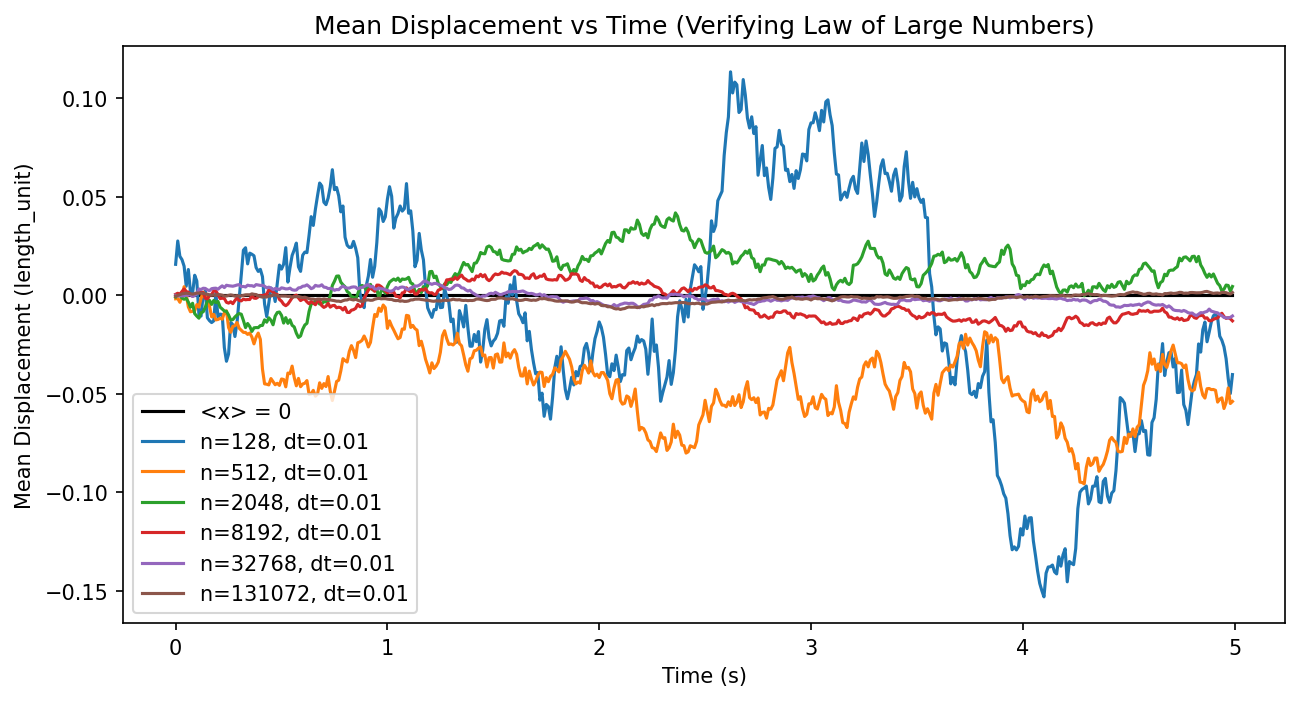

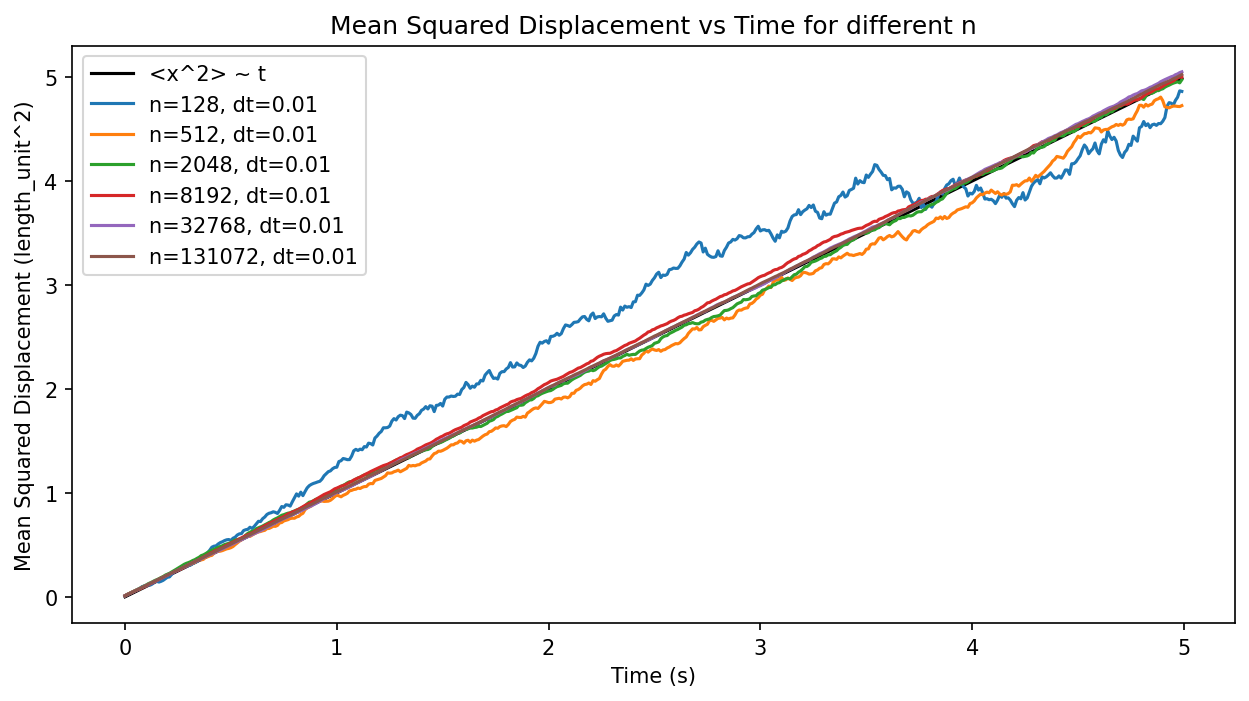

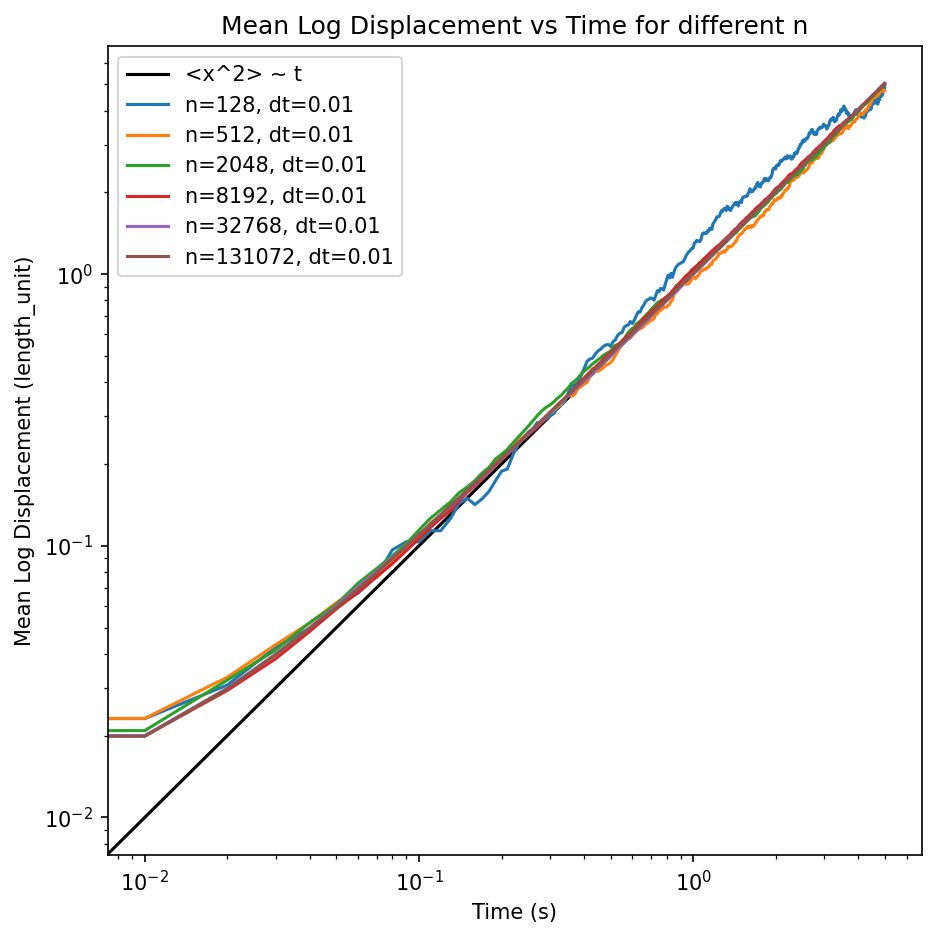

In [183]:
perform_studies_01(base_n, base_n_exponent, base_exponent_max_power, base_nt, base_dt);
# perform_studies_01(64, 2, 4, base_nt*128, base_dt*4);

In [202]:
def perform_studies_02(n_min, n_factor, n_n, dt_min, dt_max, n_dt):
    A = 1
    dts = [dt_min + i * (dt_max - dt_min) / (n_dt - 1) for i in range(n_dt)]
    err_fig, err_ax = plt.subplots(figsize=(10, 10), dpi=150)
    for ni in range(n_n):
        fig, ax = plt.subplots(figsize=(10, 10), dpi=150)
        n = n_min * (n_factor ** ni)
        
        stds = []
        for i in range(n_dt):
            dt = dts[i]
            nt = round(T/dt)
            x_vals = np.arange(nt) * dt
            trajs = cp.random.normal(size=(n, nt))  * A * np.sqrt(dt)
            
            # print(trajs.shape)
            trajs = cp.cumsum(trajs, axis=1)
            trajs_sq = cp.square(trajs)
            trajs_sq_mean = (cp.mean(trajs_sq, axis=0)).get()
            # sq_mean_vals.append([trajs_sq_mean.get()])
            deviation = trajs_sq_mean - A * A * x_vals
            std = cp.std(cp.array(deviation), axis=0).get()
            # std = cp.std(cp.array()).get()
            ax.plot(x_vals, trajs_sq_mean, label=f"dt={dt:.5g}")
            stds.append(std)
            print(f"Standard deviation for dt={dt:.5g}, n={n}: {std}")
        err_ax.plot(dts, stds, label=f"n={n}")
        print(f"Average std from exact solution for n={n}: {cp.mean(cp.array(stds)).get()}")
        print(f"")
        ax.plot(x_vals, A*A*x_vals, 'k--', label="MSD ~ t")

        # print(np.array(sq_mean_vals).shape)
        # sq_mean_vals = cp.array()
        # sq_mean_vals_std = cp.std(sq_mean_vals, axis=0)
        # average_std_dev = cp.mean(sq_mean_vals_std)
        # print(f"Average standard deviation for n={n}: {average_std_dev}")
        ax.set_xlabel("Time (s)")
        ax.set_ylabel("MSD (length_unit^2)")
        ax.set_title(f"MSD vs Time, n={n}")
        ax.legend()
        # fig.savefig(f"images/msd-vs-time_convergence-study_n={n}_dt_min={dt_min:.5g}_dt_max={dt_max:.5g}.png")
        # plt.show()

    err_ax.legend()
    err_ax.set_title(f"Deviation from Exact Solution ")
    err_ax.set_xlabel("Time (s)")
    err_ax.set_ylabel("Deviation (length_unit^2)")
    err_ax.grid()
    # err_fig.savefig(f"images/std-errors_msd-vs-time_convergence-study_n={n}_dt_min={dt_min:.5g}_dt_max={dt_max:.5g}.png")

Standard deviation for dt=0.001, n=128: 0.041553210046777596
Standard deviation for dt=0.002, n=128: 0.07386169703303946
Standard deviation for dt=0.003, n=128: 0.0587567979923614
Standard deviation for dt=0.004, n=128: 0.04310655701994917
Standard deviation for dt=0.005, n=128: 0.04533118427370738
Average std from exact solution for n=128: 0.052521889273167

Standard deviation for dt=0.001, n=512: 0.026120209113441196
Standard deviation for dt=0.002, n=512: 0.037857702774923375
Standard deviation for dt=0.003, n=512: 0.046300302239374404
Standard deviation for dt=0.004, n=512: 0.013671270540778553
Standard deviation for dt=0.005, n=512: 0.023352504933885857
Average std from exact solution for n=512: 0.02946039792048068

Standard deviation for dt=0.001, n=2048: 0.005941997950353616
Standard deviation for dt=0.002, n=2048: 0.011599613807019318
Standard deviation for dt=0.003, n=2048: 0.011431392238683178
Standard deviation for dt=0.004, n=2048: 0.009558813049597907
Standard deviation fo

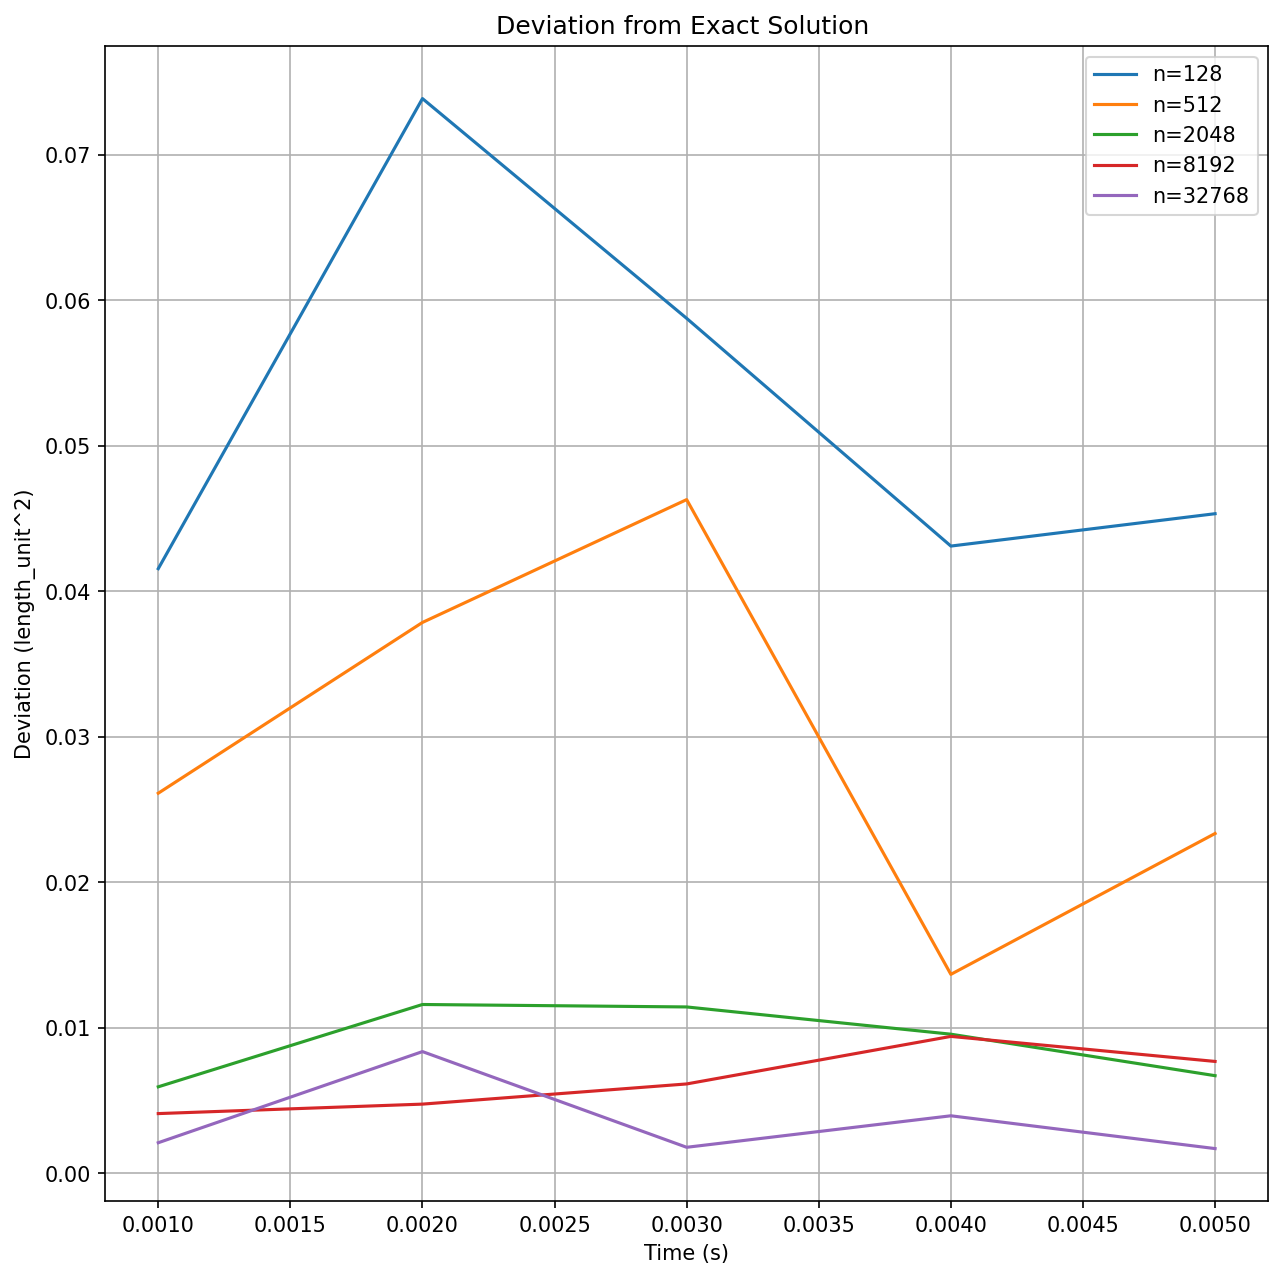

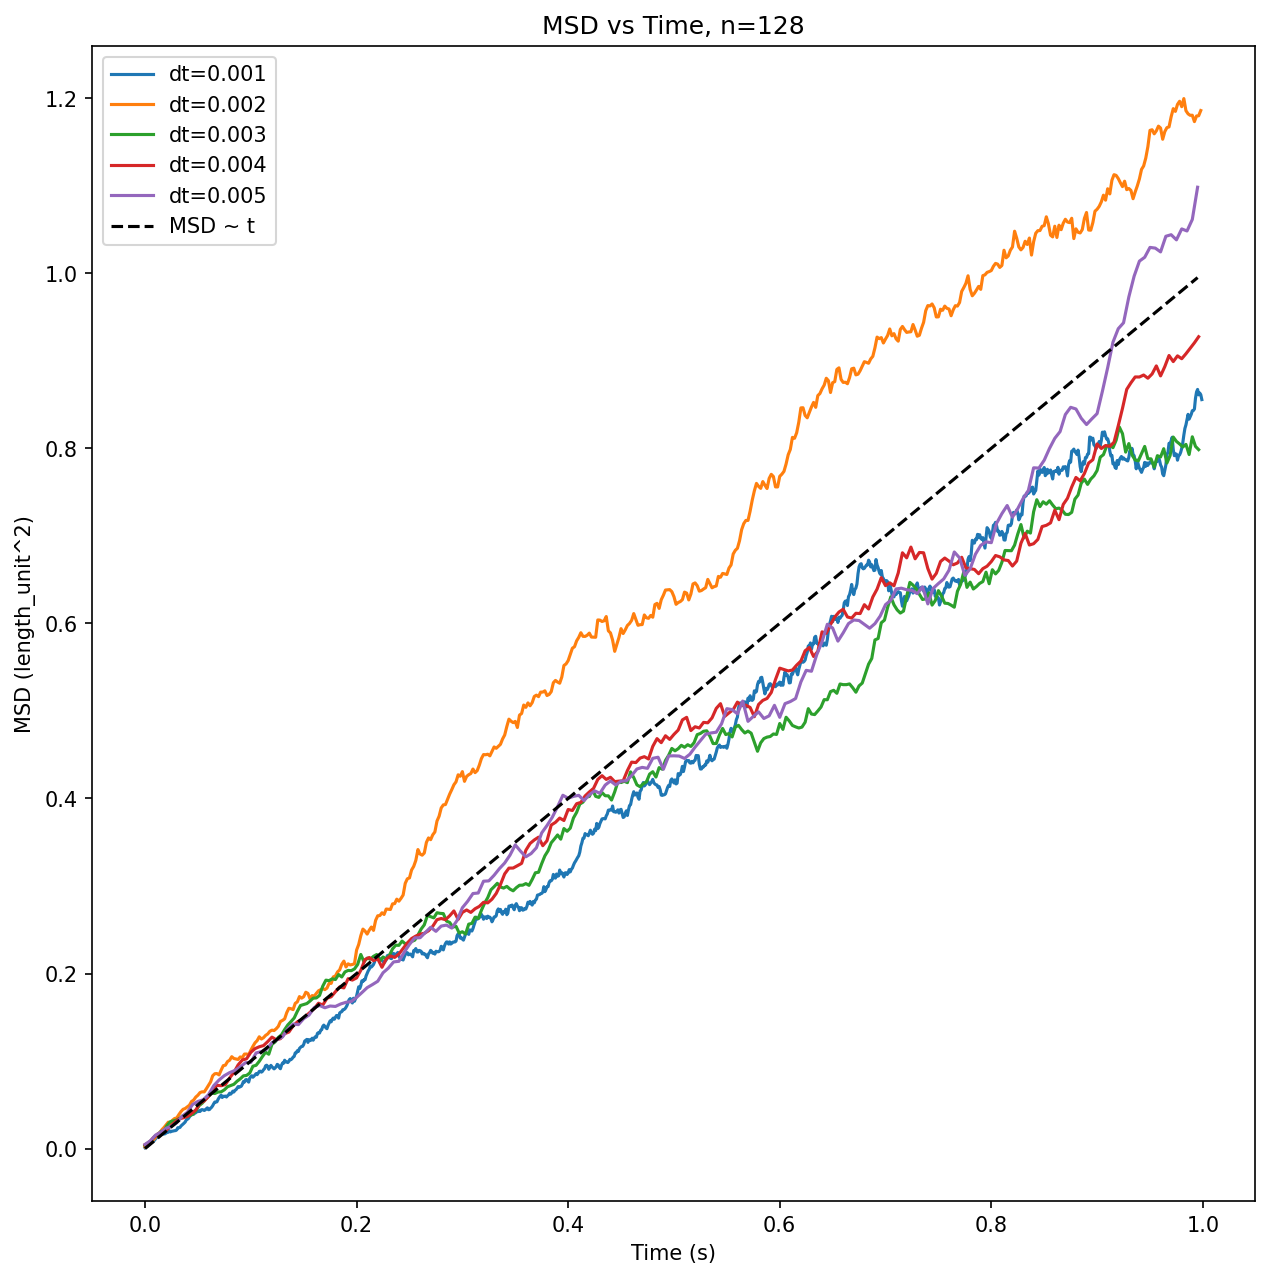

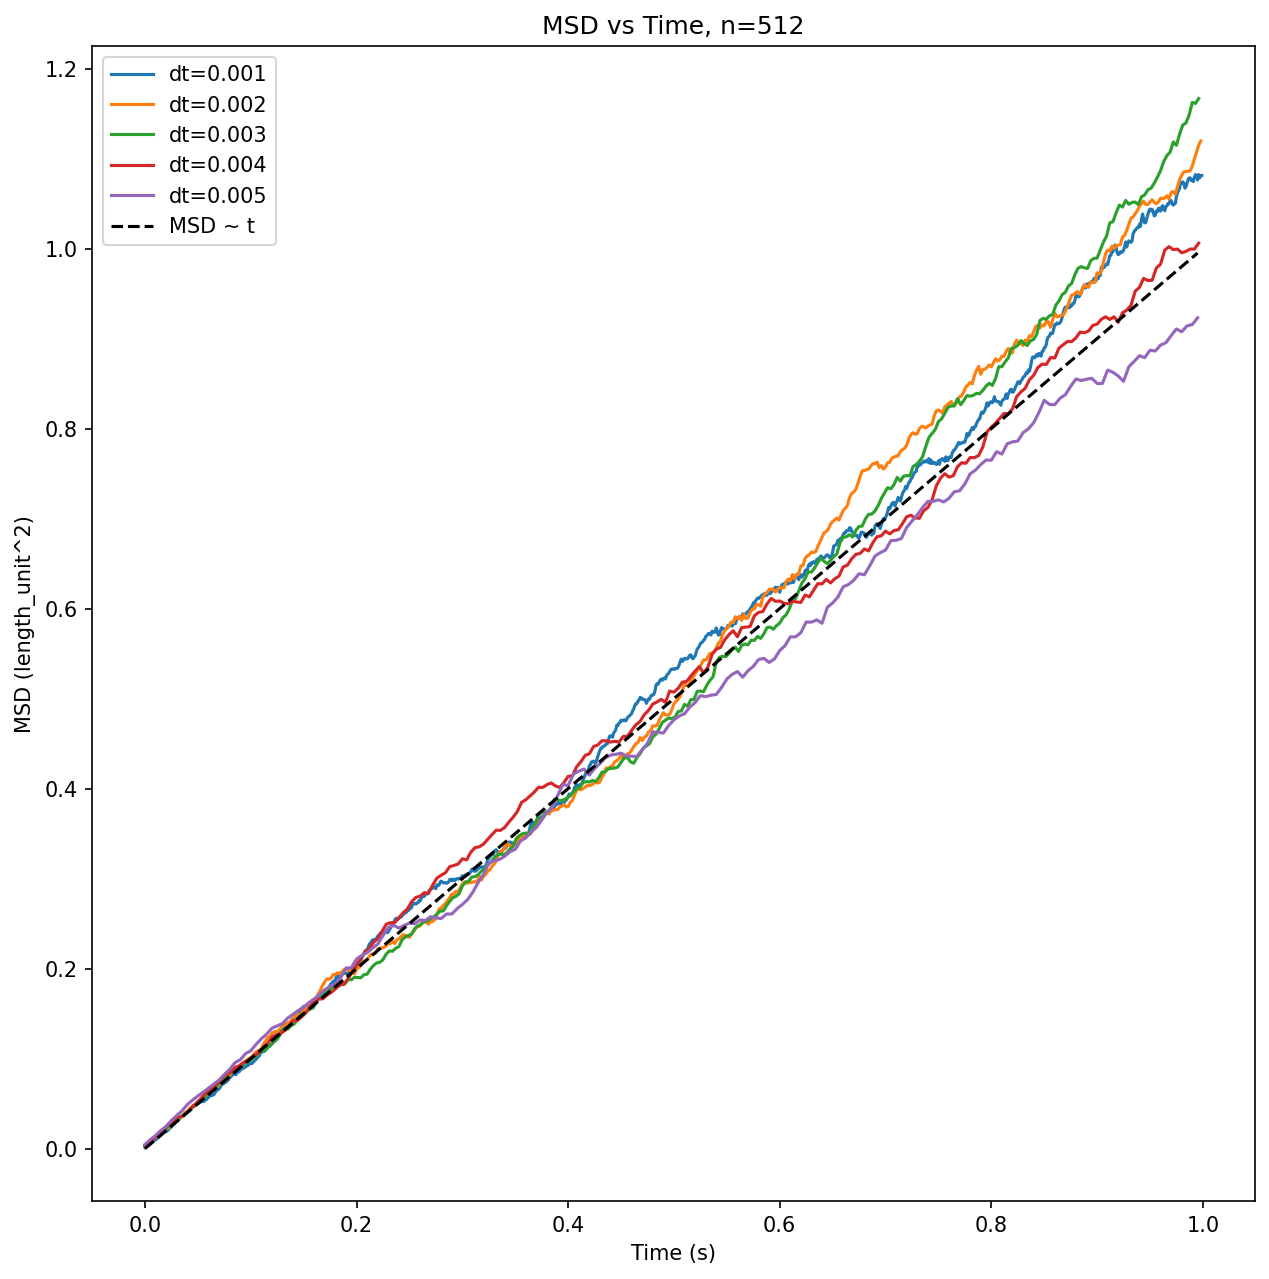

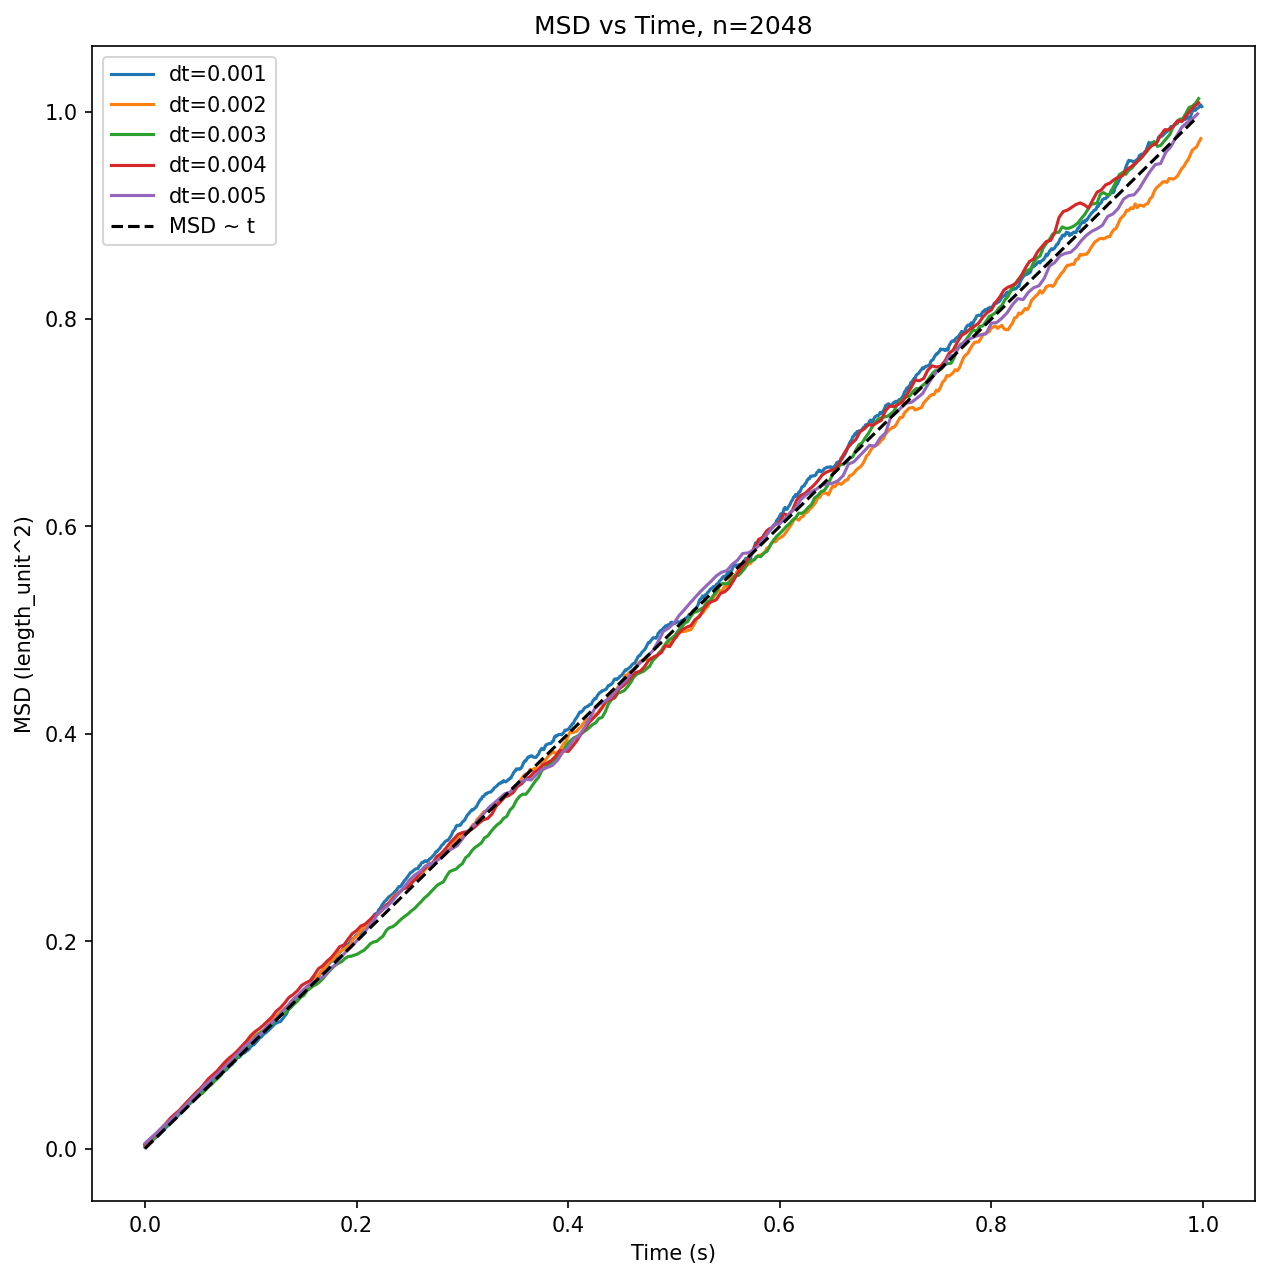

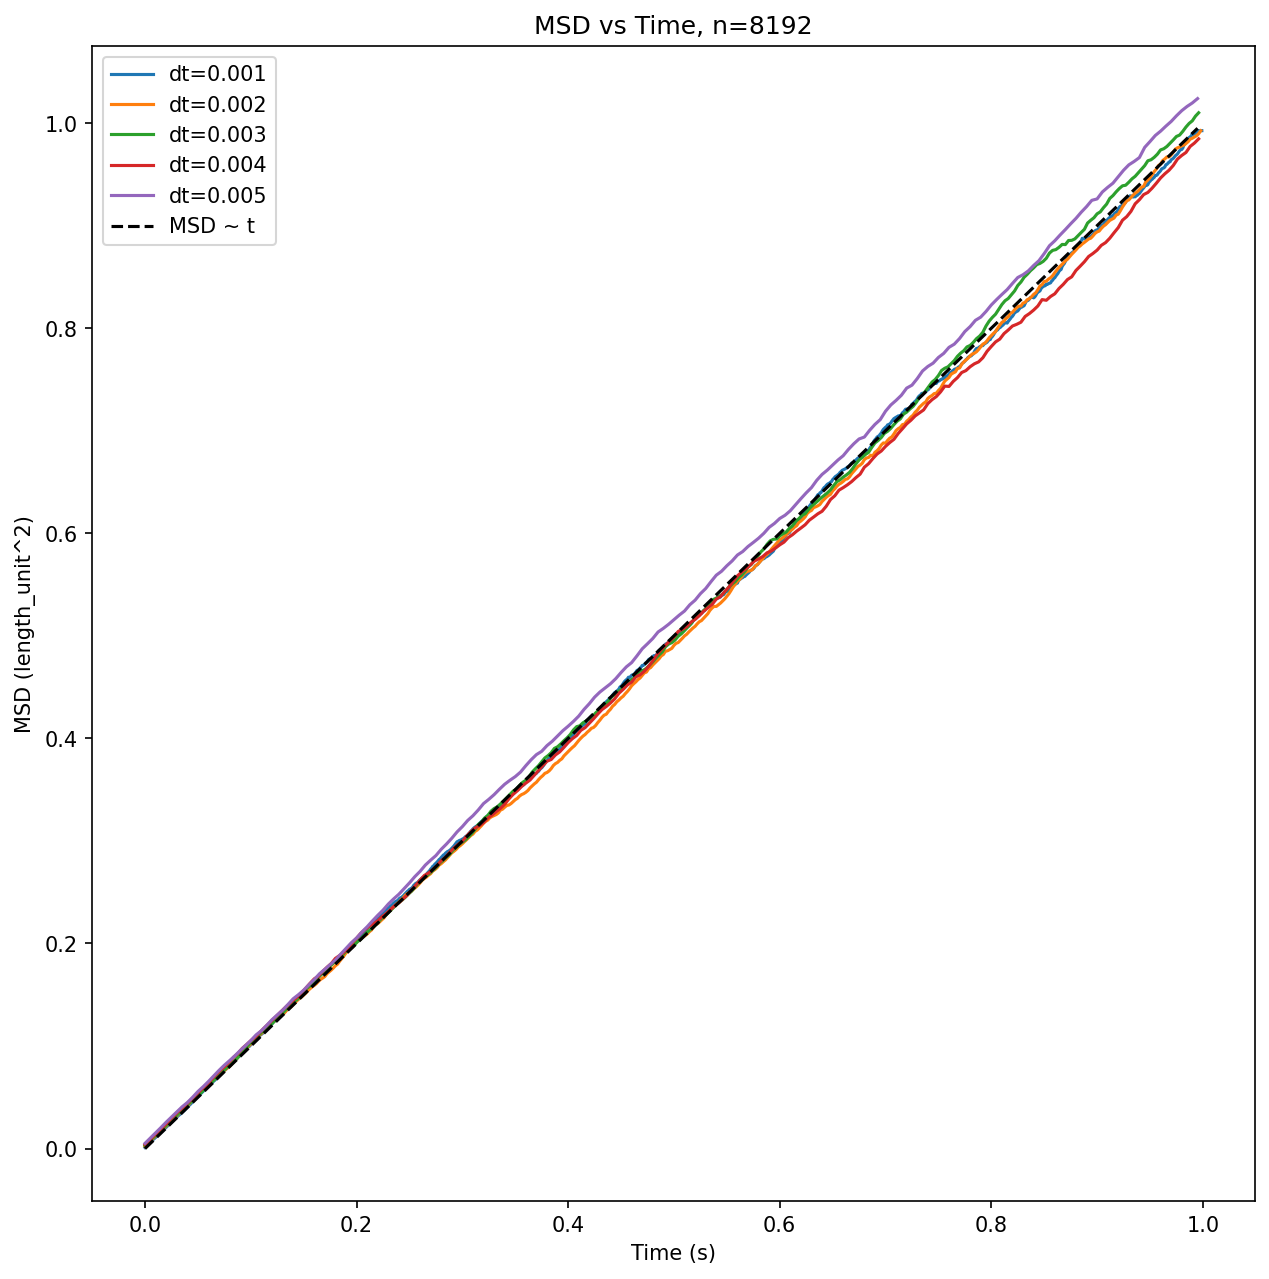

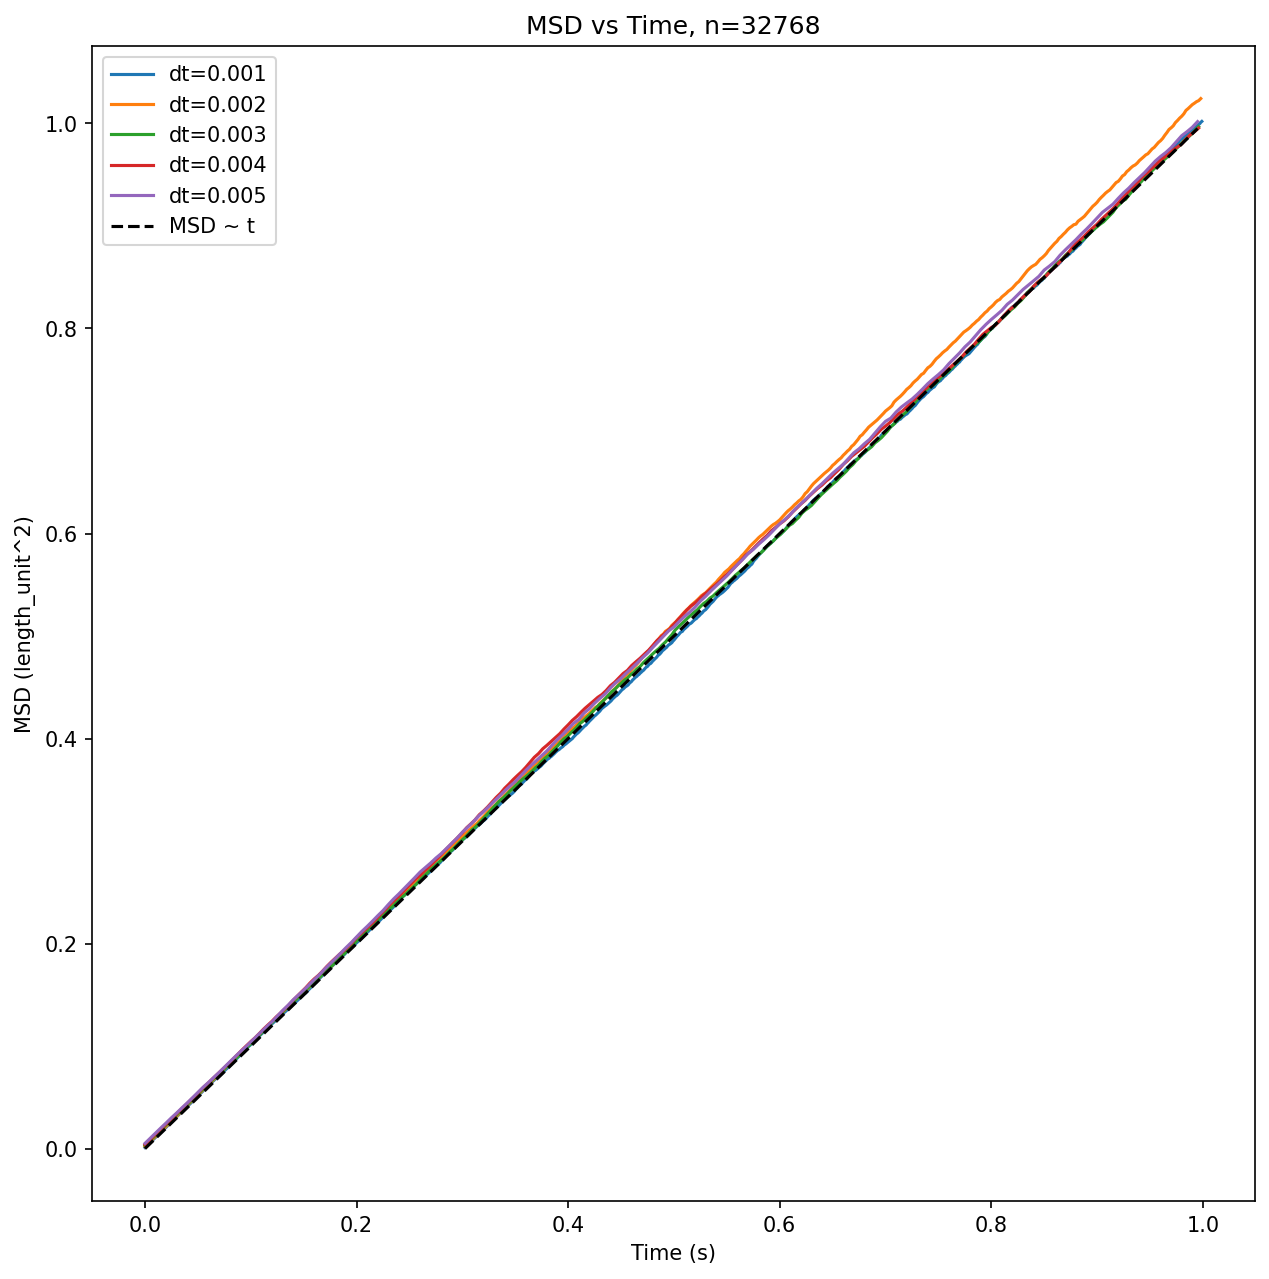

In [ ]:
perform_studies_02(base_n, base_n_exponent, base_exponent_max_power, base_min_dt, base_dt*0.5, base_n_dt);
perform_studies_02(base_n, base_n_exponent, base_exponent_max_power, base_min_dt, base_dt*0.5, base_n_dt);

In [263]:
def perform_studies_02_05(n_min, n_factor, n_n, dt_min, dt_base_exp, n_dt, T):
    A = 1
    dts = [dt_min * (dt_base_exp**i) for i in range(n_dt)]
    log_dts = [np.log10(dt) for dt in dts]
    err_fig, err_ax = plt.subplots(figsize=(10, 10), dpi=150)
    for ni in range(n_n):
        fig, ax = plt.subplots(figsize=(10, 10), dpi=150)
        n = n_min * (n_factor ** ni)
        
        stds = []
        for i in range(n_dt):
            dt = dts[i]
            nt = round(np.ceil(T/dt))
            x_vals = (np.arange(nt) * dt) + dt
            trajs = cp.random.normal(size=(n, nt))  * A * np.sqrt(dt)
            
            # print(trajs.shape)
            trajs = cp.cumsum(trajs, axis=1)
            trajs_sq = cp.square(trajs)
            trajs_sq_mean = (cp.mean(trajs_sq, axis=0)).get()
            # sq_mean_vals.append([trajs_sq_mean.get()])
            deviation = trajs_sq_mean - A * A * x_vals
            std = cp.sum(cp.square(cp.array(deviation))) / nt
            # std = cp.std(cp.array()).get()
            ax.plot(x_vals, trajs_sq_mean, label=f"dt={dt:.5g}")
            stds.append(np.sqrt(std.get()))
            print(f"Standard deviation for dt={dt:.5g}, n={n}: {std}")
        err_ax.plot(dts, stds, label=f"n={n}")
        err_ax.set_xscale('log')
        print(f"Average std from exact solution for n={n}: {cp.mean(cp.array(stds)).get()}")
        print(f"")
        ax.plot(x_vals, A*A*x_vals, 'k--', label="MSD ~ t")

        # print(np.array(sq_mean_vals).shape)
        # sq_mean_vals = cp.array()
        # sq_mean_vals_std = cp.std(sq_mean_vals, axis=0)
        # average_std_dev = cp.mean(sq_mean_vals_std)
        # print(f"Average standard deviation for n={n}: {average_std_dev}")
        ax.set_xlabel("Time (s)")
        ax.set_ylabel("MSD (length_unit^2)")
        ax.set_title(f"MSD vs Time, n={n}")
        ax.legend()
        fig.savefig(f"images/msd-vs-time_convergence-study_exponential-dt_n={n}_dt_min={dt_min:.5g}_dt_max={dts[-1]:.5g}.png")
        # plt.show()
    
    err_ax.legend()
    err_ax.set_title(f"Deviation(RMS) from exact solution (Length_unit)")
    err_ax.set_xlabel("dt (s)")
    err_ax.set_ylabel("Root Mean Square Error (length_unit)")
    err_ax.grid()
    err_fig.savefig(f"images/std-errors_exponential-dt_msd-vs-time_convergence-study_n={n}_dt_min={dt_min:.5g}_dt_max={dts[-1]:.5g}.png")

Standard deviation for dt=0.0005, n=128: 0.008094722198942788
Standard deviation for dt=0.001, n=128: 0.001925050796936159
Standard deviation for dt=0.002, n=128: 0.002427734508353756
Standard deviation for dt=0.004, n=128: 0.009396896365202353
Standard deviation for dt=0.008, n=128: 0.001244386361683707
Standard deviation for dt=0.016, n=128: 0.0066823531709727275
Standard deviation for dt=0.032, n=128: 0.005007357592450015
Standard deviation for dt=0.064, n=128: 0.005230196408086944
Standard deviation for dt=0.128, n=128: 0.005111506399652633
Average std from exact solution for n=128: 0.06796164610509248

Standard deviation for dt=0.0005, n=512: 0.008994281271108476
Standard deviation for dt=0.001, n=512: 0.0027108558429018983
Standard deviation for dt=0.002, n=512: 0.0017264927874461053
Standard deviation for dt=0.004, n=512: 0.000618632909301759
Standard deviation for dt=0.008, n=512: 0.0014903823036617303
Standard deviation for dt=0.016, n=512: 0.001600304184212039
Standard deviat

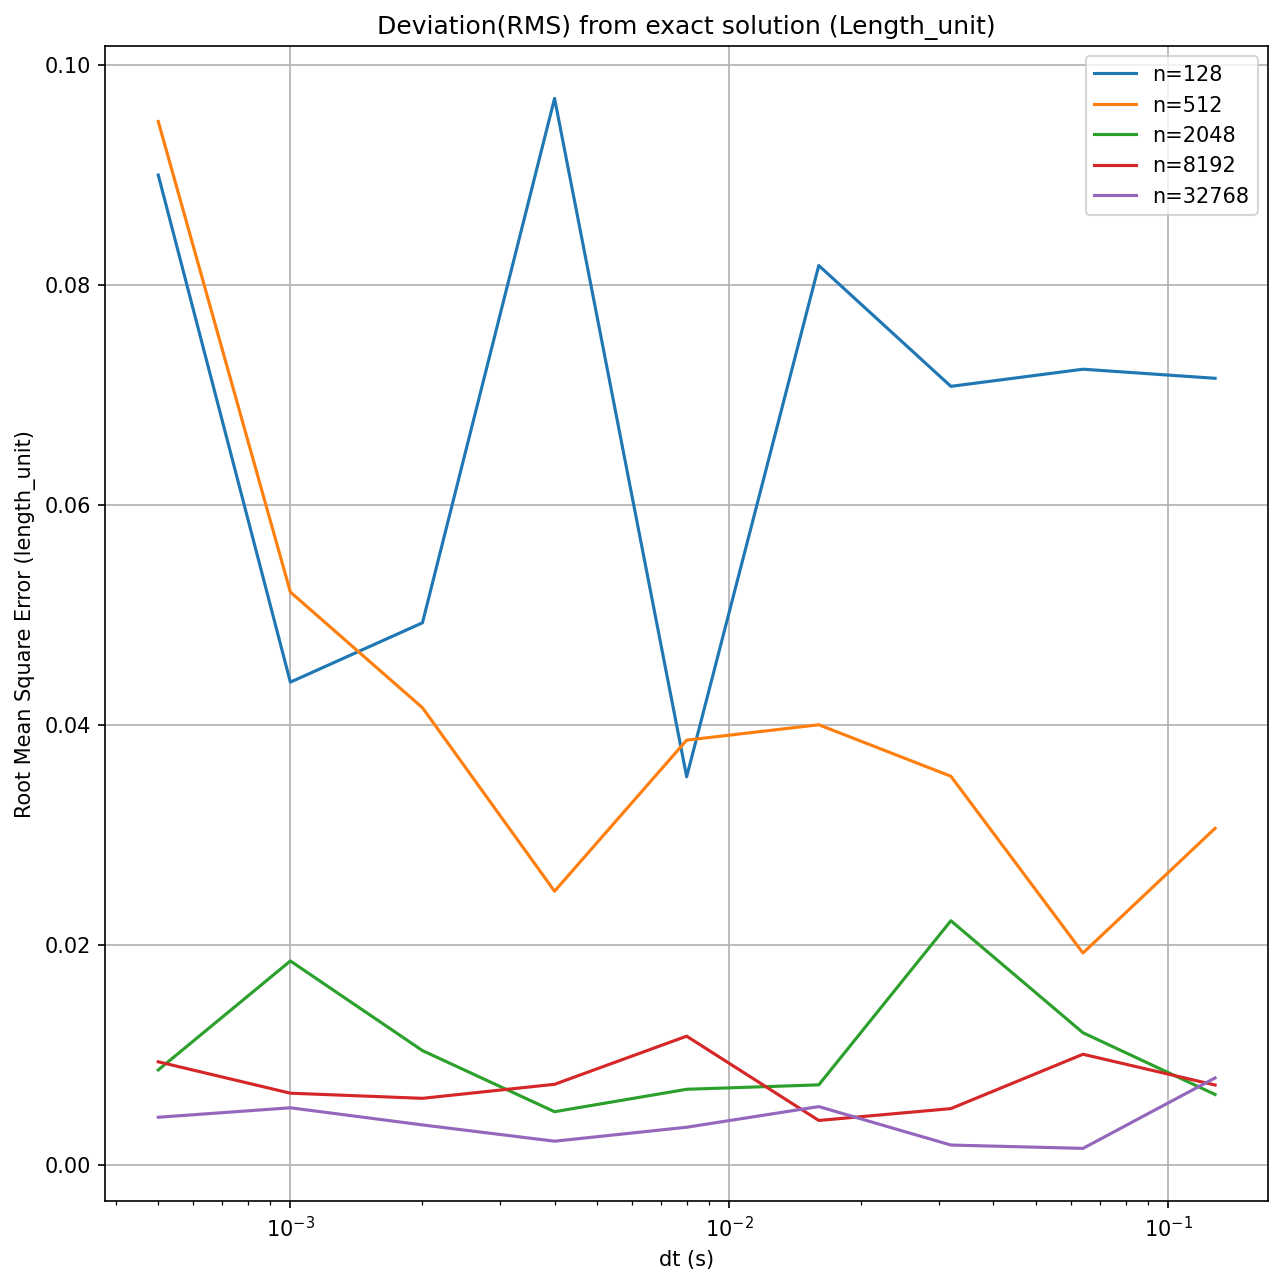

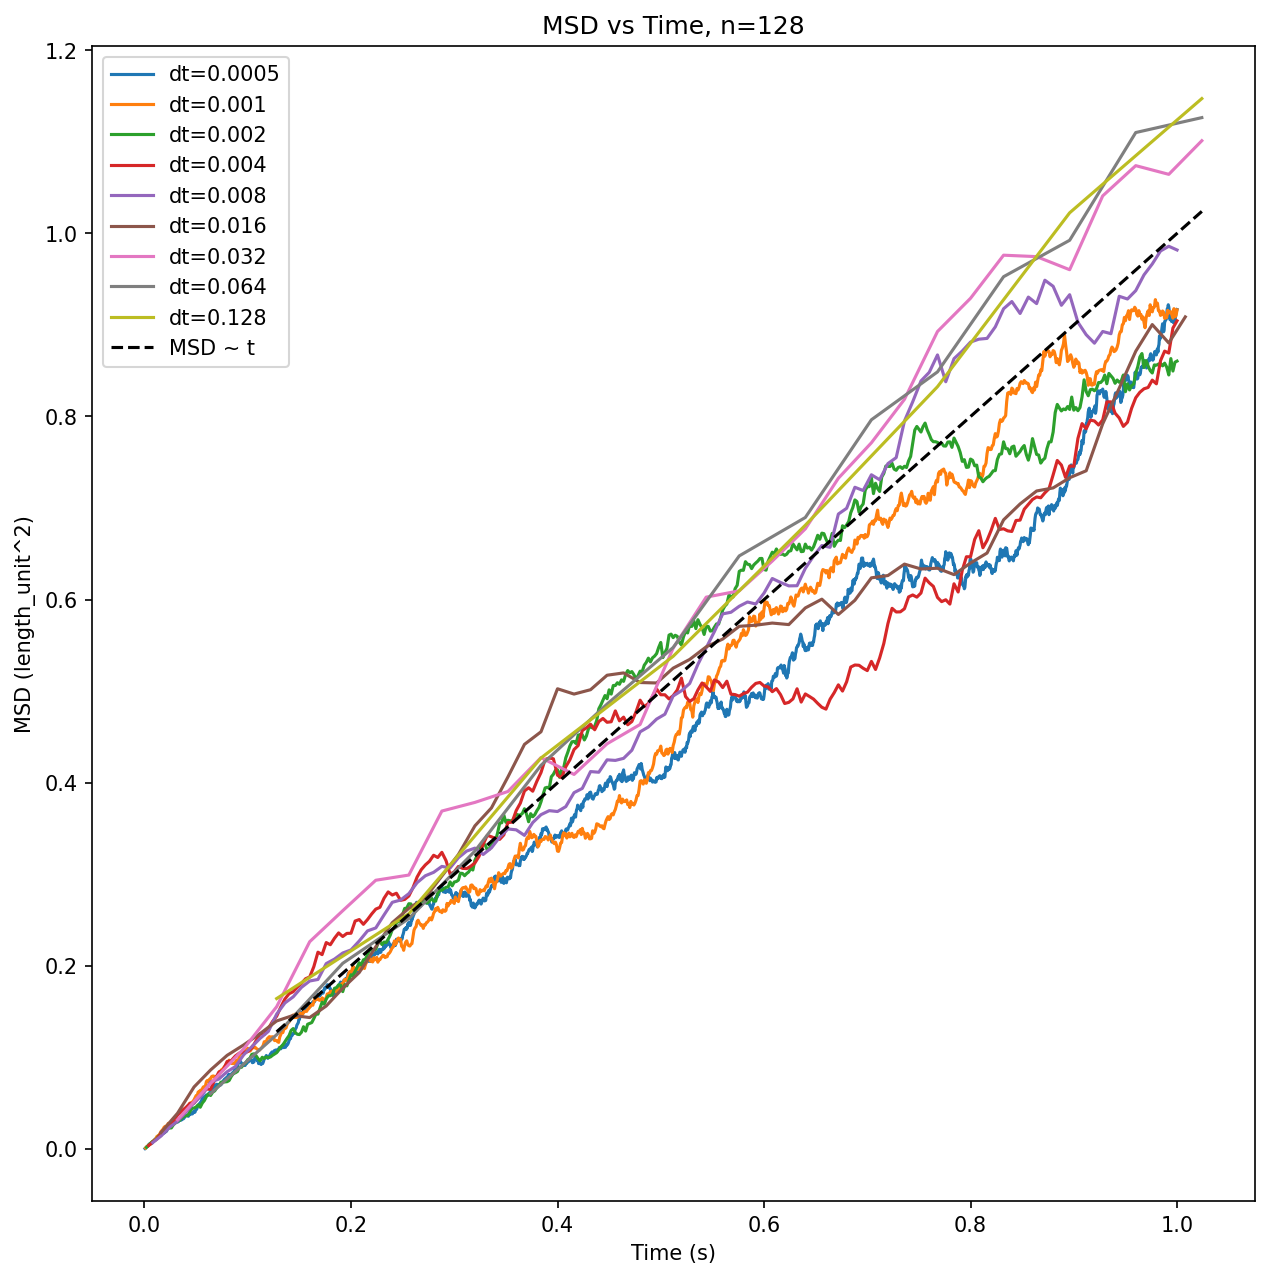

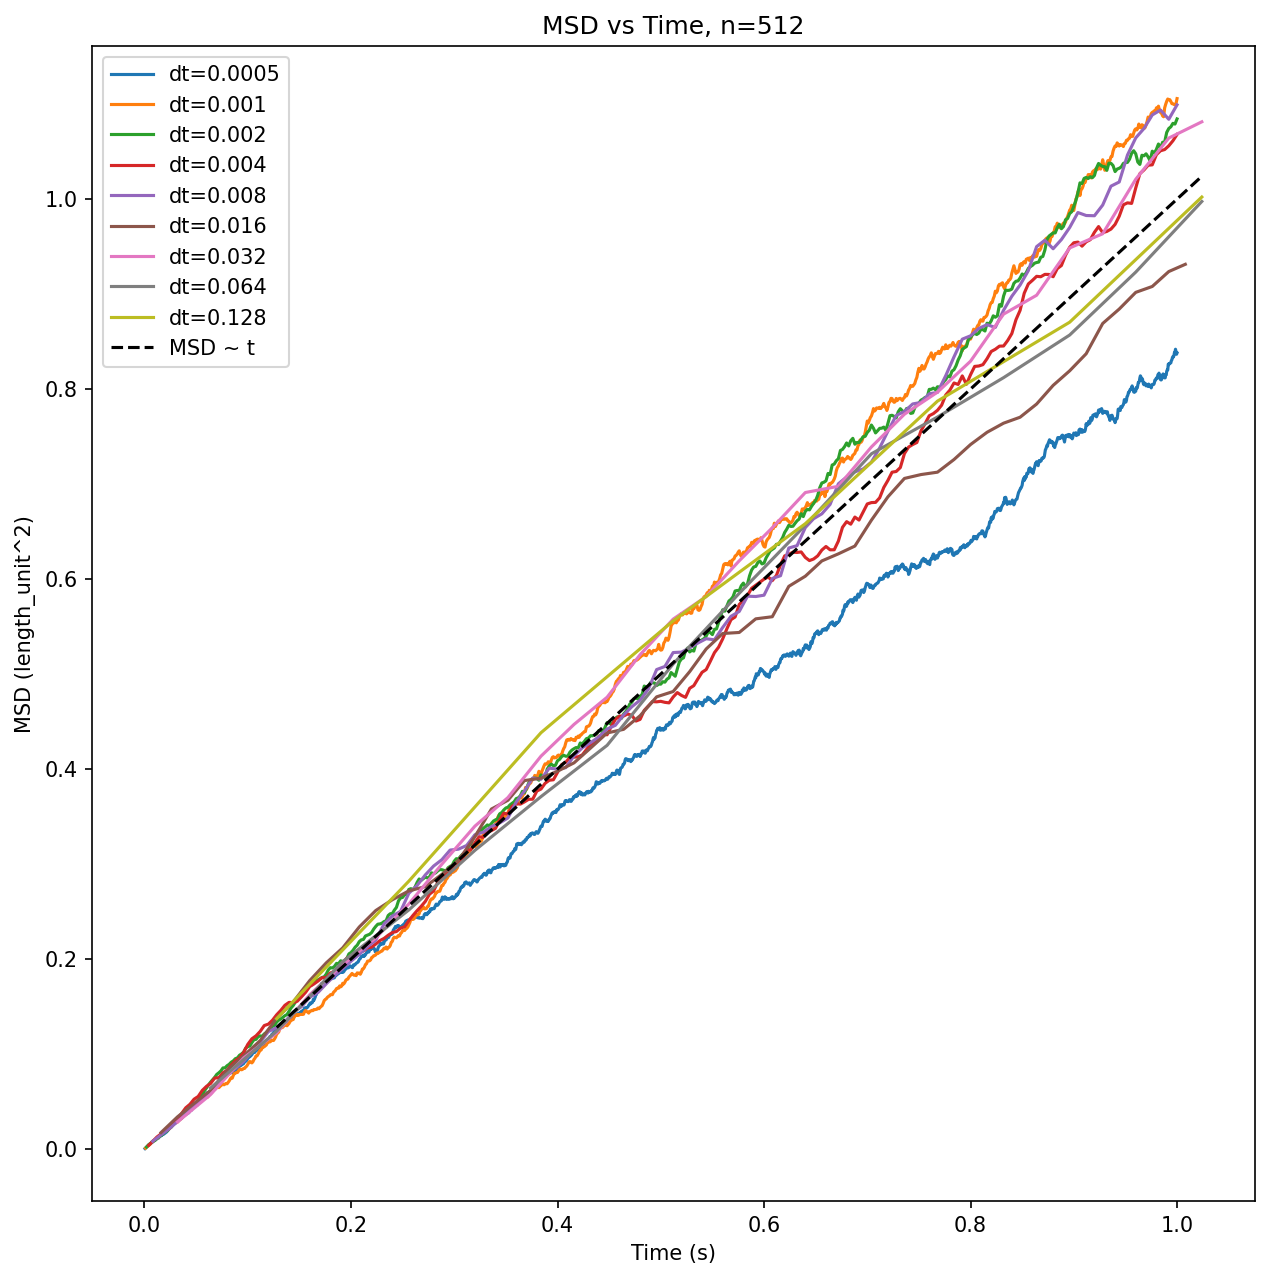

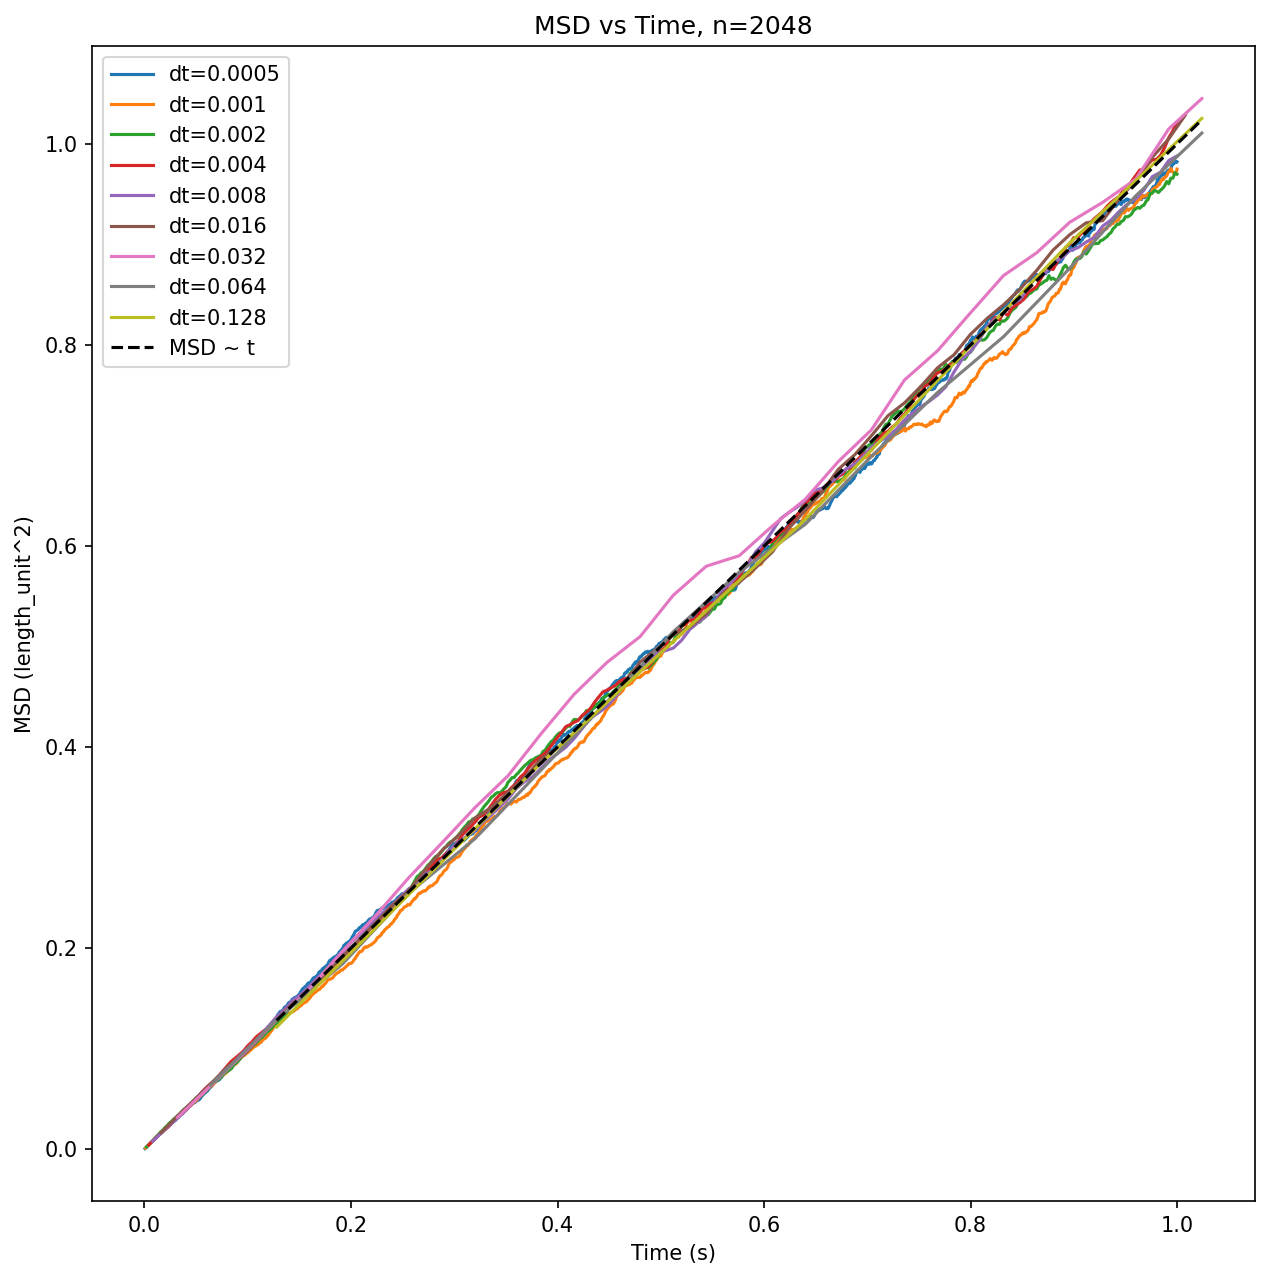

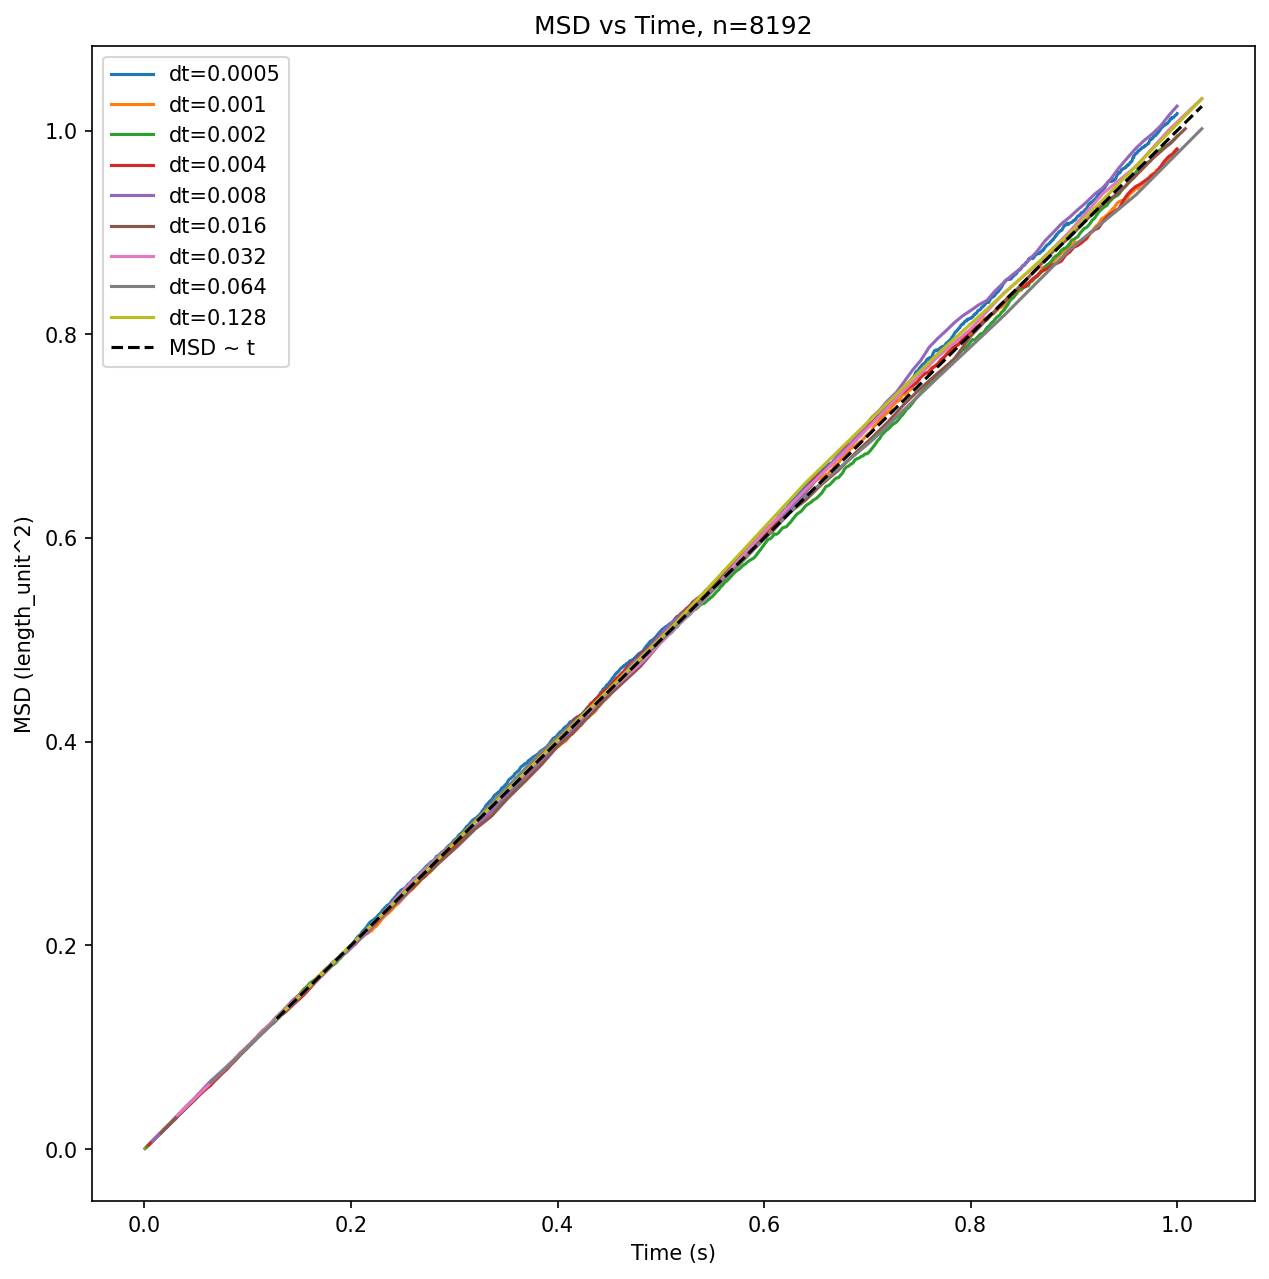

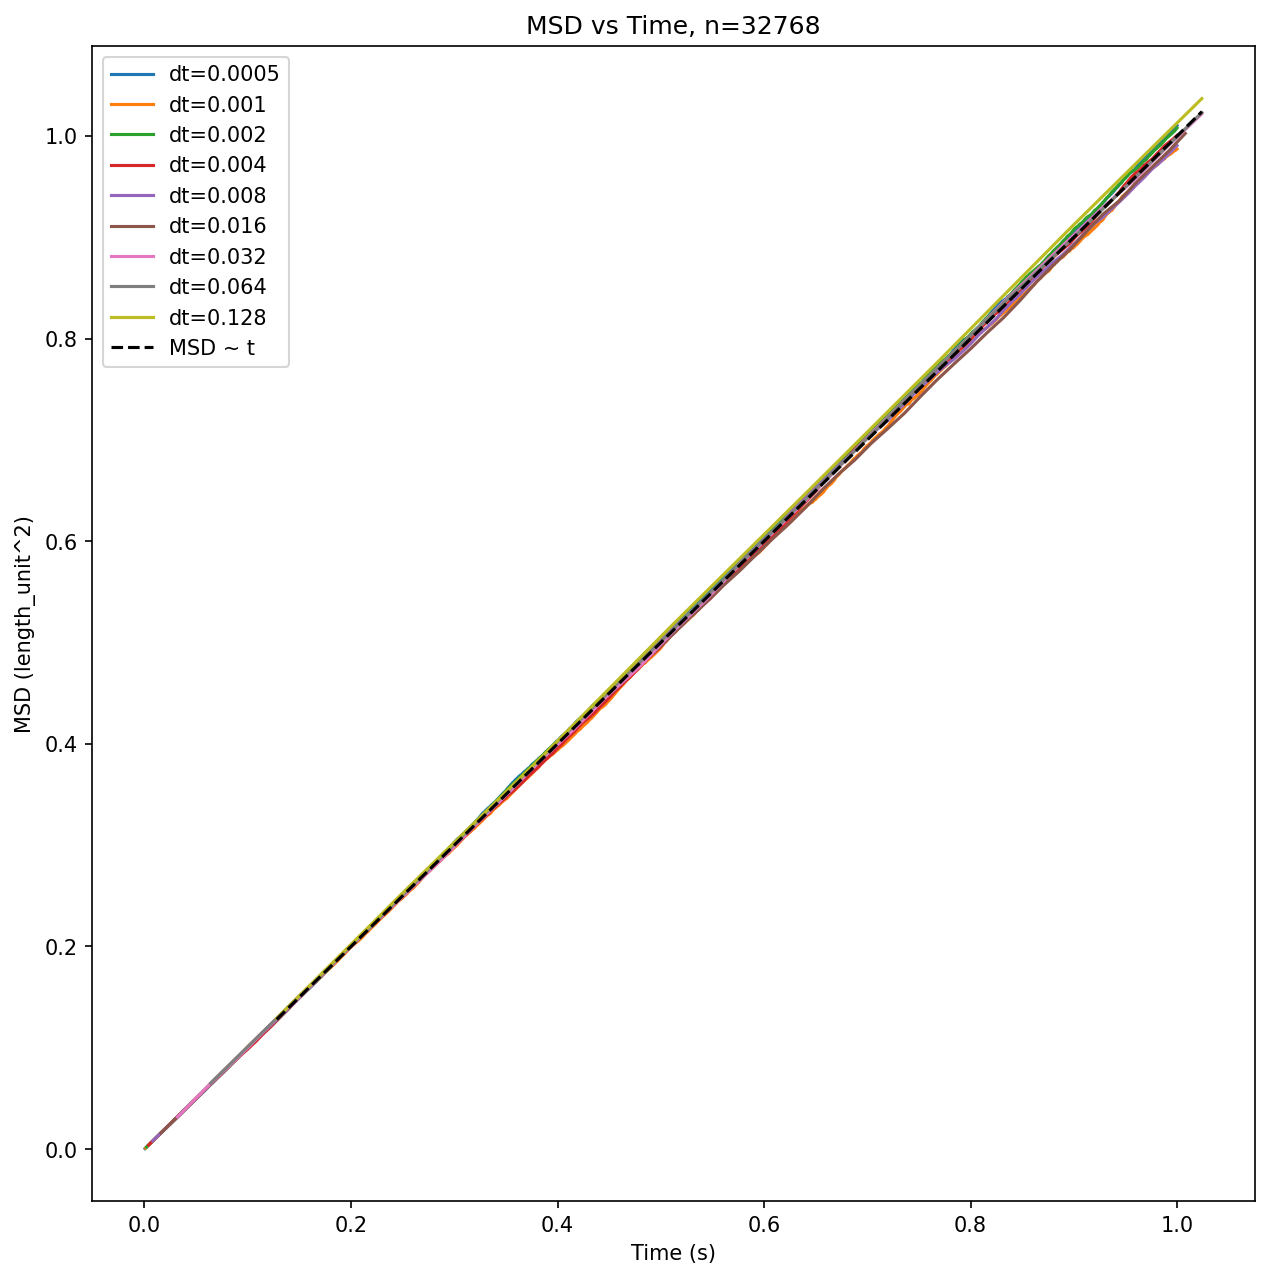

In [264]:
perform_studies_02_05(base_n, base_n_exponent, base_exponent_max_power, base_min_dt*0.5, 2, 9, 1)

In [249]:
def perform_studies_03(n_min, n_factor, n_n, dt_min, dt_max, n_dt, T):
    A = 1
    num_distributions = 3
    hsl1 = 0.5*(1/num_distributions)+0.1
    hsl2 = hsl1 + (1/num_distributions)
    dhsl = (1/num_distributions)*0.7
    hsl3 = hsl2 + (1/num_distributions)
    

    for i_t in range(n_dt):
        dt = dt_min + i_t * (dt_max - dt_min) / (n_dt - 1)
        nt = round(T/dt)
        fig, ax= plt.subplots(figsize=(10, 10), dpi=150)
        
    
        sq_mean_vals = []
        stds = []
        x_vals = np.arange(nt) * dt
        
        for ni in range(n_n):
            n = n_min * (n_factor ** ni)
            trajs = cp.random.normal(size=(n, nt)) * A * cp.sqrt(dt)
            trajs = cp.cumsum(trajs, axis=1)
            trajs_sq = cp.square(trajs)
            trajs_sq_mean = (cp.mean(trajs_sq, axis=0)).get()
            ax.plot(x_vals, trajs_sq_mean, color=cs.hsv_to_rgb(hsl1 + dhsl * ni/n_n, 1.0, 1.0), label=f"n={n}, Gaussian")
        
            trajs = cp.random.uniform(low=-A/2, high=A/2, size=(n, nt)) * cp.sqrt(dt/(1/12))
            trajs = cp.cumsum(trajs, axis=1)
            trajs_sq = cp.square(trajs)
            trajs_sq_mean = cp.mean(trajs_sq, axis=0).get()
            ax.plot(x_vals, trajs_sq_mean, color=cs.hsv_to_rgb(hsl2 + dhsl * ni/n_n, 1.0   , 1.0), label=f"n={n}, Uniform")
            
            trajs = cp.random.exponential(scale=A*np.sqrt(dt), size=(n, nt)) - A*cp.sqrt(dt)
            trajs = cp.cumsum(trajs, axis=1) 
            trajs_sq = cp.square(trajs)
            trajs_sq_mean = cp.mean(trajs_sq, axis=0).get()
            ax.plot(x_vals, trajs_sq_mean, color=cs.hsv_to_rgb(hsl3 + dhsl * ni/n_n, 1.0   , 1.0), label=f"n={n}, Exponential")
            
            
        ax.set_xlabel("Time (s)")
        ax.set_ylabel("MSD (length_unit^2)")
        ax.set_title(f"MSD vs Time, Gaussian vs Uniform vs Exponential(Grouped by hue), dt={dt:.5g}")
        ax.plot(x_vals, A**2 * x_vals, 'k--', label="MSD ~ t")
        ax.legend()
        fig.savefig(f"images/msd-vs-time_distribution-study_dt={dt:.5g}_n-min={n_min}_n-max={n_min*(n_factor**(n_n-1))}.png")

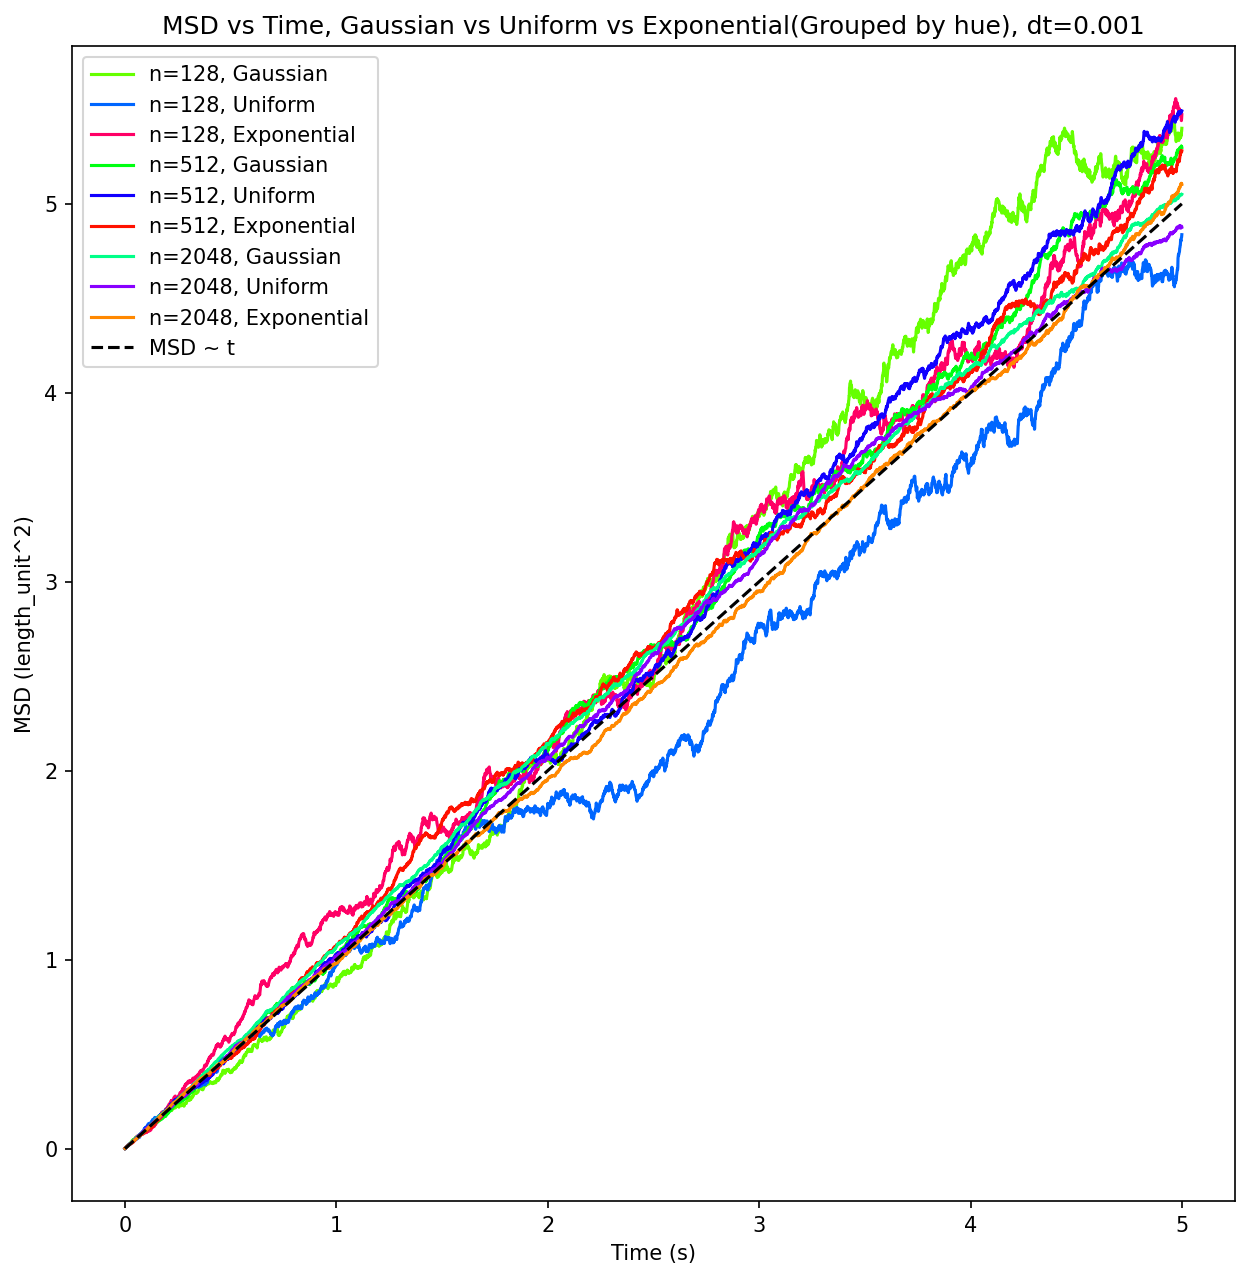

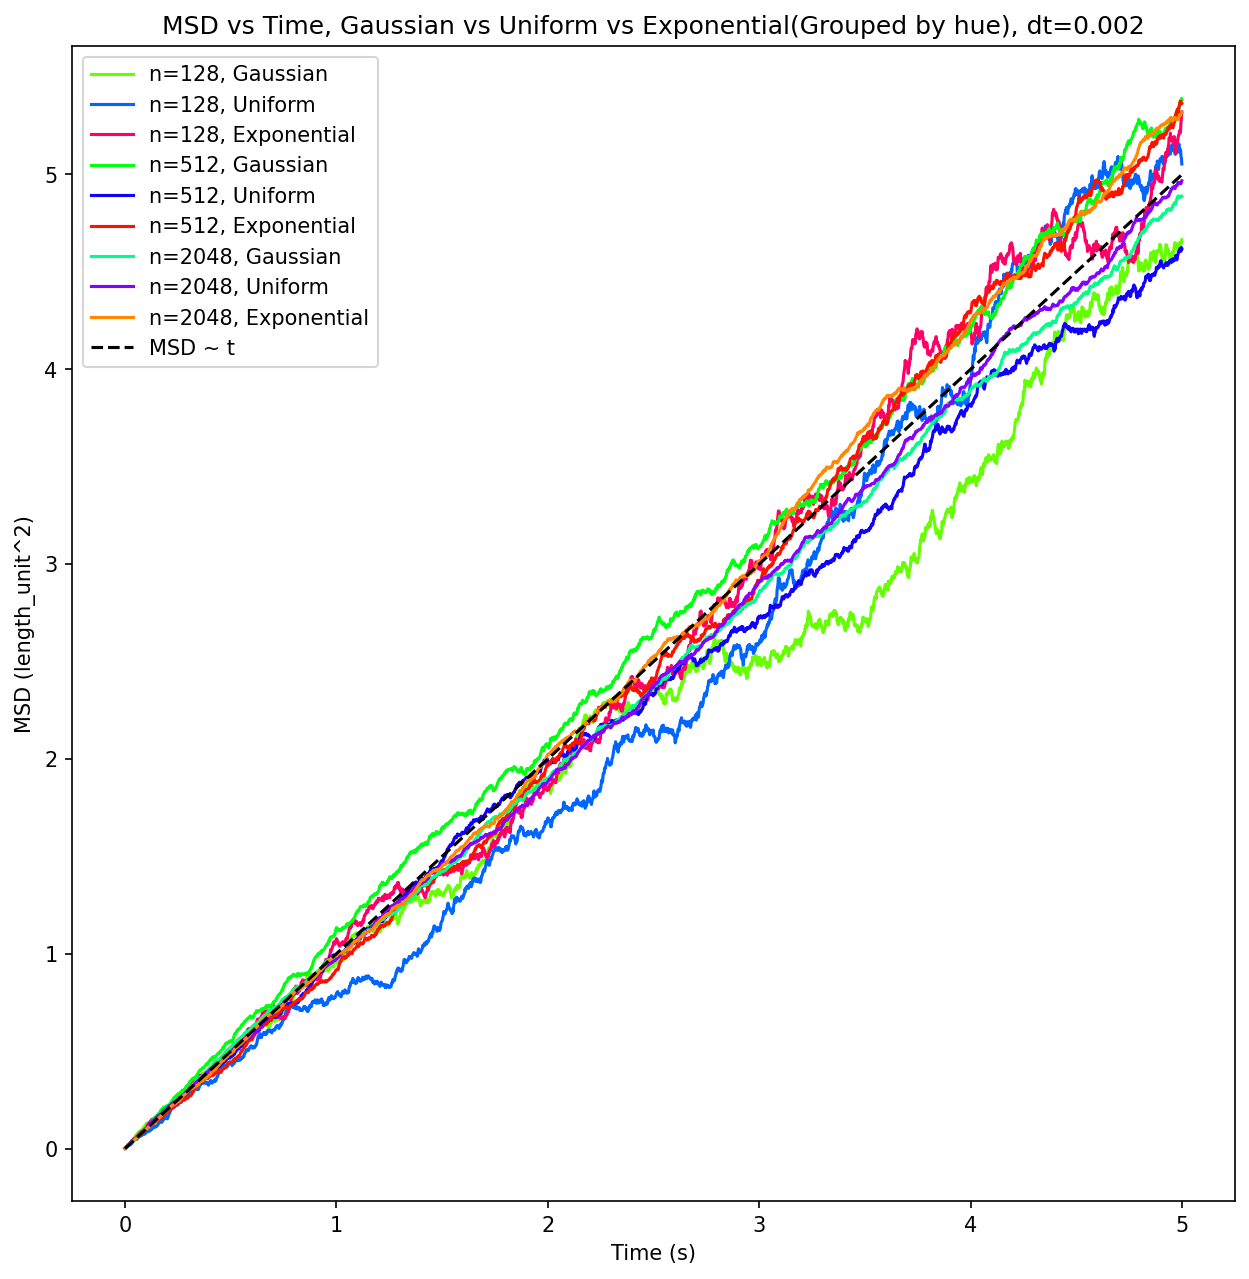

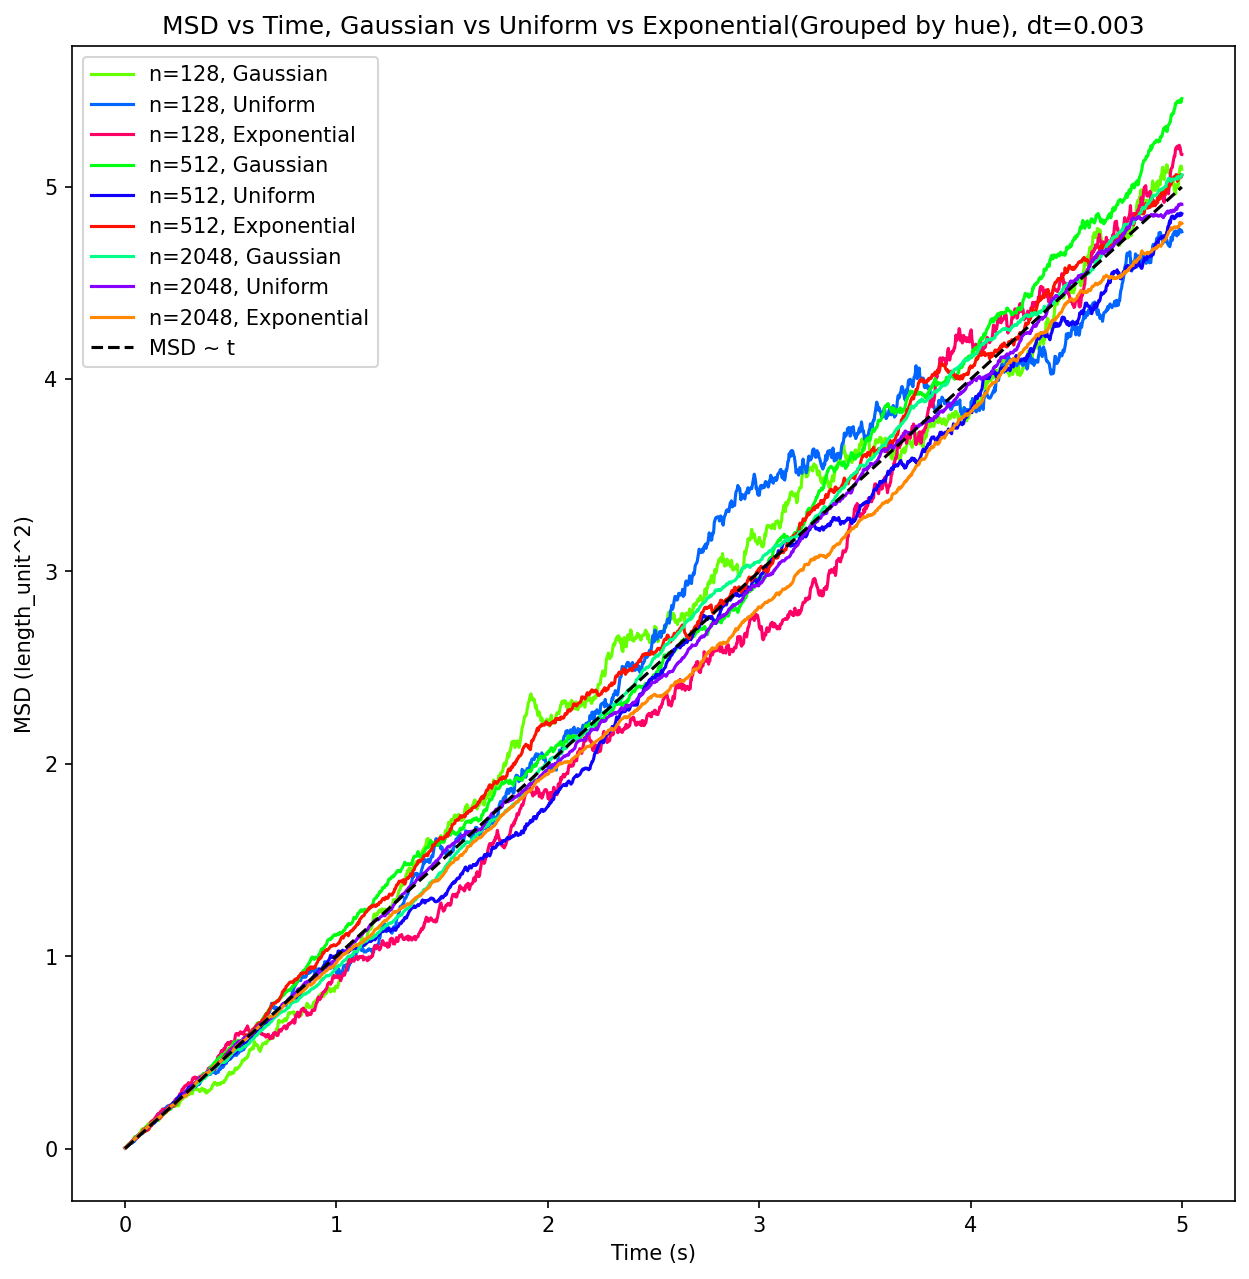

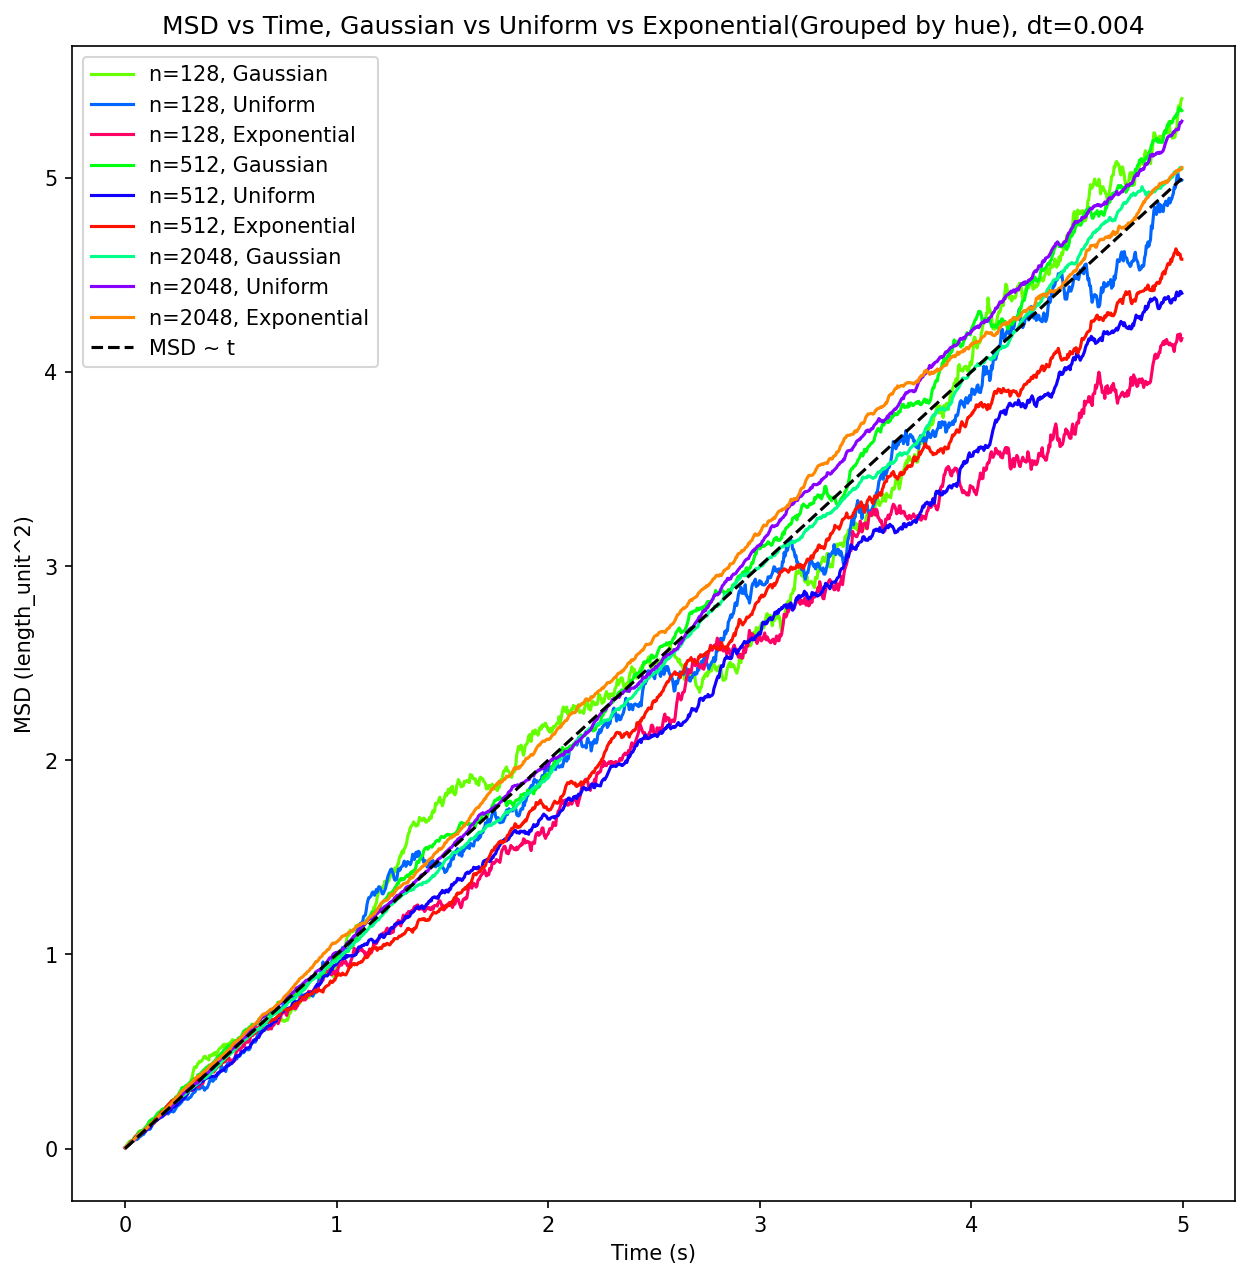

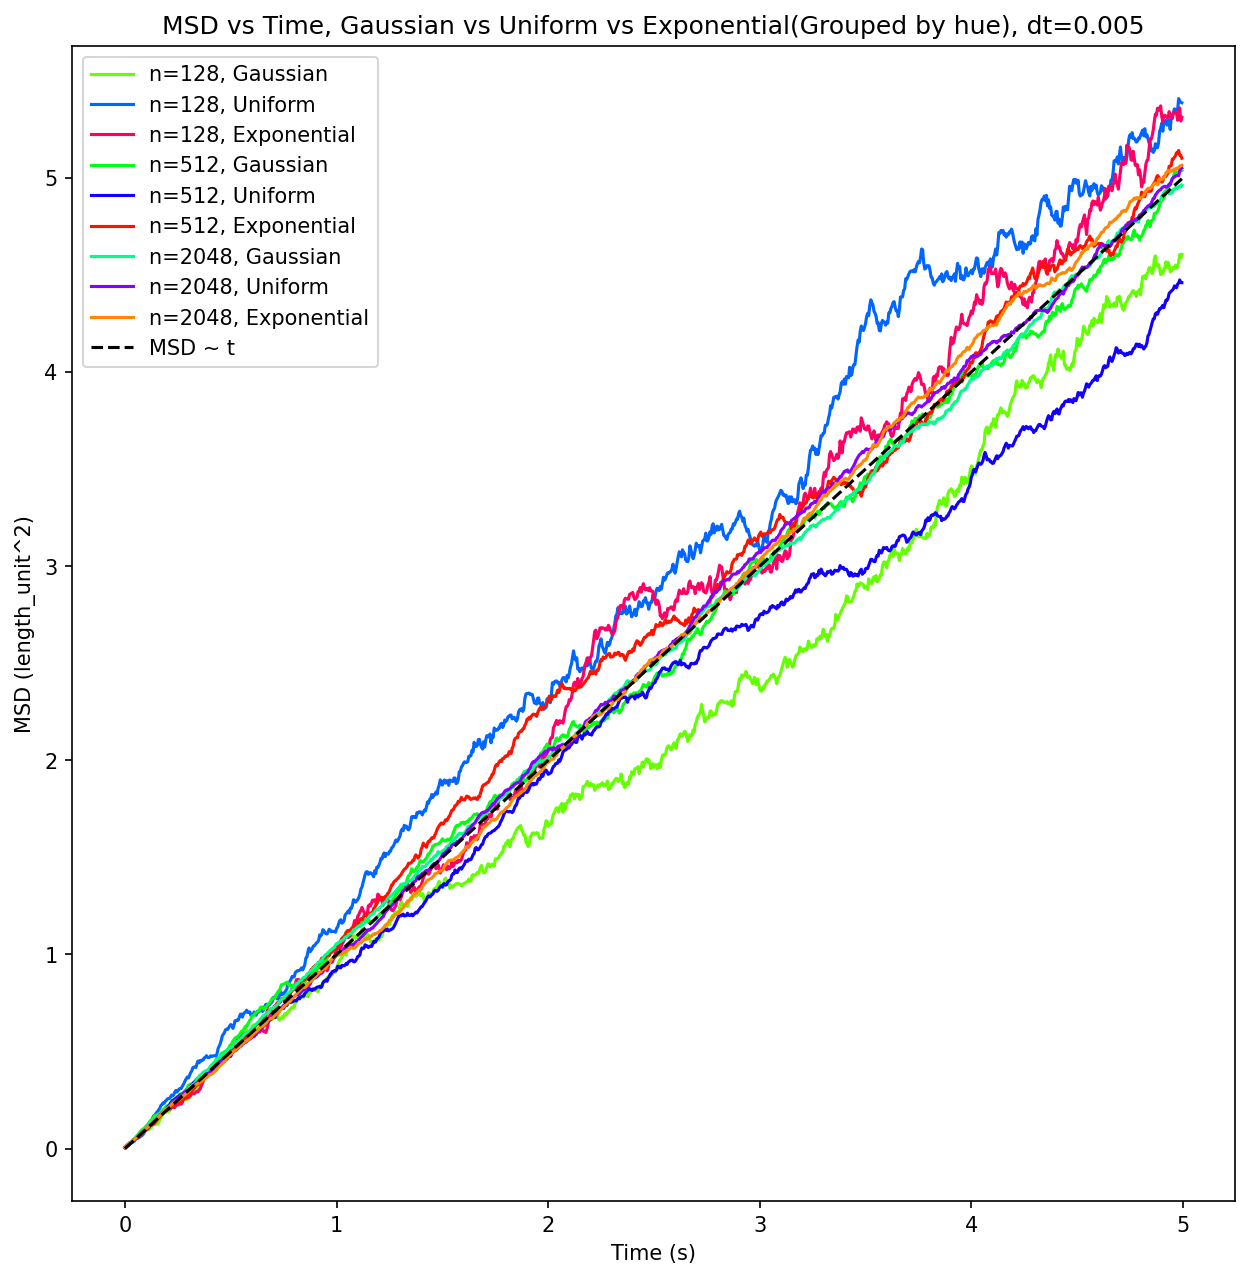

In [265]:
perform_studies_03(base_n, base_n_exponent, base_exponent_max_power-2, base_min_dt, base_dt*0.5, base_n_dt, base_T);